# Final Project: CT Scans for COVID-19 Classification

## Class: CSCI-E 25

Kacper Lewtak


## Abstract:

Modern medical imaging has proven time and again to be a field which could see immense benefit from the utilization of computer vision networks in aiding professionals of the medical field. COVID-19 continues to affect individuals with compromised immune systems and can often lead to secondary infections. For this project, we look into the image classification abilities of several model architectures: ResNetV2, EfficientNetV2, and ConvNeXt.

The goal of this project is to test how well these architectures are able to perform in a classification task, as well as conclude whether or not they might be suitable for a real world implementation in a professional medical setting.

<a id="contents"></a>

# Table of Contents
- [**Library Import**](#import)
- [**Loading Data**](#data_load)
- [**Comprehensive EDA Review**](#review)
    - [Dimensionality](#dimensionality)
    - [Viewing images, channels and inspecting channel differences](#differences)
    - [Pixel Distributions](#distributions)
    - [EDA Conclusions](#eda_conclusions)
- [**Image Preprocessing**](#preprocessing)
- [**Data Augmentaion and Pipeline**](#aug_pipeline)
- [**Training Existing Model Architectures**](#training)
- [**Model Testing and Conclusions**](#model_testing)
- [**Sources**](#sources)

# Library Import <div id='import'>

In [ ]:
import random
random.seed(25)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings

import sys
import time
import pickle
from natsort import natsorted

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters.rank import equalize
from skimage import exposure
from skimage import color
from skimage import io

from sklearn.metrics import classification_report, average_precision_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

import time
import arviz as az
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as sk

# TensorFlow and tf.keras
import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive')
img_dir = './data/archive/'
# img_dir = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/data/processed/'

In [ ]:
# Run this code to mitigate memory growth on the gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading Data <div id='data_load'>

In [ ]:
def get_images(files, directory):
    # Creating blank list to store all images
    img_list = []

    for img_file in files:
        img_path = os.path.join(img_dir+directory, img_file)

        with Image.open(img_path) as img:
            img_list.append(np.array(img))
    return img_list

In [ ]:
# Getting the directory list of both the negative, positive and non-informative ct scans
nct_files = natsorted(os.listdir(img_dir+'nCT'))
pct_files = natsorted(os.listdir(img_dir+'pCT'))
nict_files = natsorted(os.listdir(img_dir+'niCT'))


# preparing image lists
nCT = get_images(nct_files, 'nCT')
pCT = get_images(pct_files, 'pCT')
niCT = get_images(nict_files, 'niCT')

# Comprehensive EDA Review <div id='review'>

The dataset contains a total of 19,685 images spread across three different classes: Negative CT Scan, Positive CT Scan, and Uninformative CT Scan. An initial overview shows that there is an inherent data imbalance to the overall dataset, as the images are unevenly split in quantity across the three categories. Images classified as negative made up just over half of the dataset with 50.7% of all images. The next largest category was the Non-Informative classification which consists of 29%. Images classified as being positive for COVID-19 pneumonia only made up 20.3% of the overall dataset.

The structure of the overall dataset is as follows:

#### Data Archive
- Original CT Scans
  - nCT (9979 images)
  - NiCT (5705 images)
  - pCT (4001 images)
- Preprocessed CT Scans
  - nCT (9979 images)
  - NiCT (5705 images)
  - pCT (4001 images)


Likewise there is a mix of image resolutions contained in the dataset. The majority of the images have a 512x512 image resolution, however there is still a significant portion of images which have other resolutions. It is important to note that the distribution of image resolutions differs across the three different classifications.

A visual inspection of the data shows that the non-informative images are drastically different from the negative/positively classified images.

## Dimensionality <div id='dimensionality'>

A rather peculiar detail about the imported images is that they have seemingly 3 color channels. I suspect this is an artifact of the method used to import the images into the notebook. Nonetheless, we will inspect the images later to test for any additional information being stored in those channels.

In [ ]:
# Checking the dimensions of the image
print(nCT[0].shape)

(512, 512, 3)


In [ ]:
def count_dimensions(img_list):
    img_dict = {}

    for img in img_list:
        # First, store the dimensions
        dim = img.shape

        # Check if the dimension type has been accounted for
        if dim in img_dict:
            img_dict[dim] += 1
        # Otherwise, we add the dimension type and increment
        else:
            img_dict[dim] = 1

    return img_dict

In [ ]:
# Checking the dimensions of all images in nCT and pCT
nCT_dim = count_dimensions(nCT)
pCT_dim = count_dimensions(pCT)
niCT_dim = count_dimensions(niCT)

for dims, count in nCT_dim.items():
    print(f"nCT Dimensions: {dims}, Count: {count}")

print('\n')

for dims, count in pCT_dim.items():
    print(f"pCT Dimensions: {dims}, Count: {count}")

print('\n')

for dims, count in niCT_dim.items():
    print(f"niCT Dimensions: {dims}, Count: {count}")

nCT Dimensions: (512, 512, 3), Count: 7641
nCT Dimensions: (575, 575, 3), Count: 1153
nCT Dimensions: (574, 574, 3), Count: 204
nCT Dimensions: (1211, 1211, 3), Count: 981


pCT Dimensions: (512, 512, 3), Count: 2081
pCT Dimensions: (575, 575, 3), Count: 1170
pCT Dimensions: (1211, 1211, 3), Count: 750


niCT Dimensions: (512, 512, 3), Count: 3739
niCT Dimensions: (575, 575, 3), Count: 1127
niCT Dimensions: (1211, 1211, 3), Count: 738
niCT Dimensions: (574, 574, 3), Count: 101


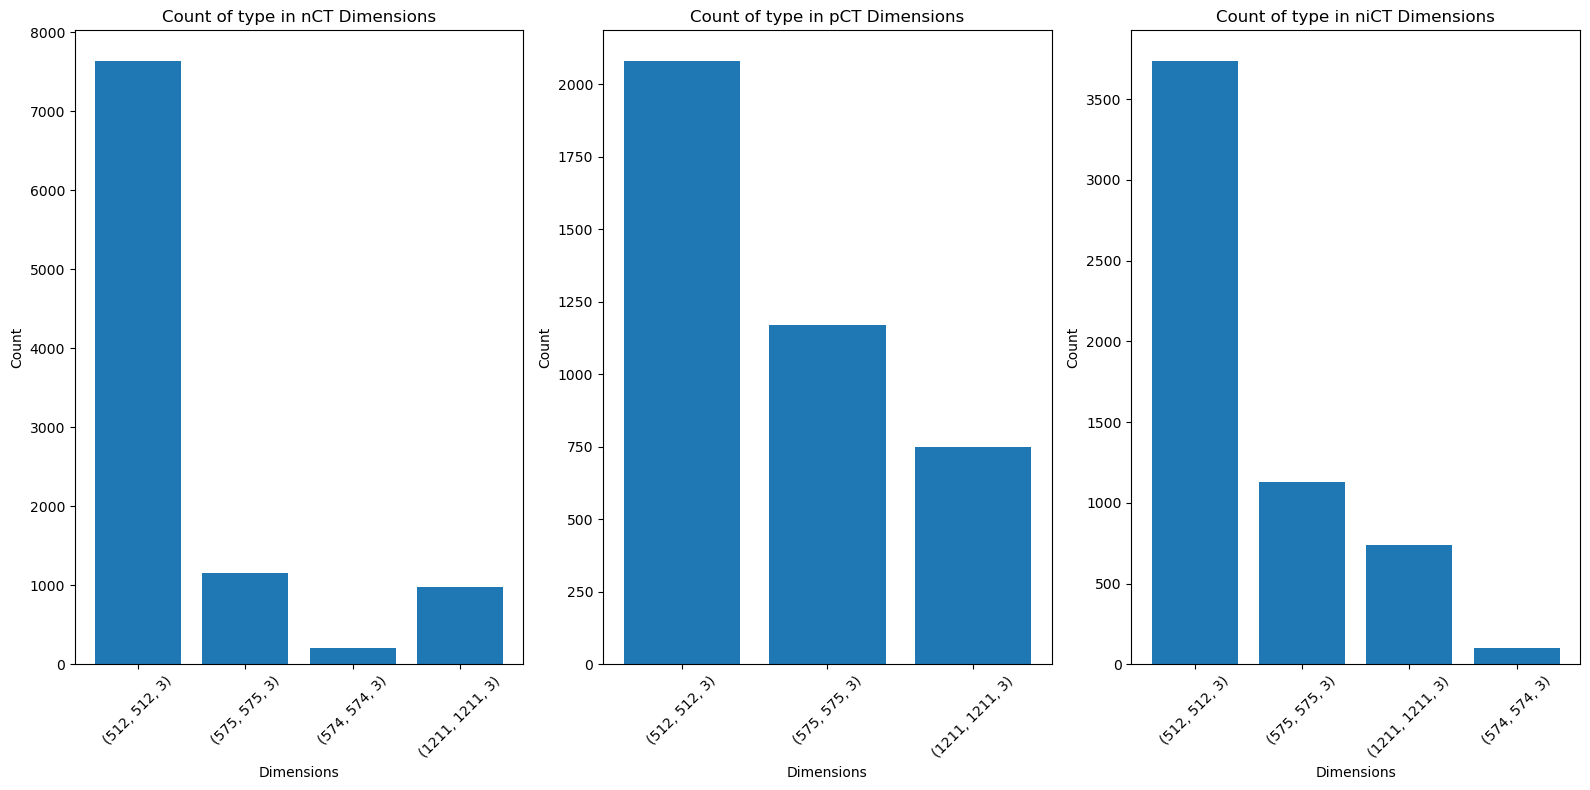

In [ ]:
def plot_dimensions(dims_list, data):
    fig, axs = plt.subplots(1, len(dims_list), figsize=(16,8))  # Create subplots

    for i in range(len(data)):
        dimensions = dims_list[i]
        dataset = data[i]
        dim = [str(key) for key in dimensions.keys()]
        count = list(dimensions.values())

        axs[i].bar(range(len(dimensions)), count, tick_label=dim)
        axs[i].set_title(f'Count of type in {dataset}')
        axs[i].set_xlabel('Dimensions')
        axs[i].set_ylabel('Count')
        plt.sca(axs[i])
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_dimensions([nCT_dim, pCT_dim, niCT_dim], ['nCT Dimensions', 'pCT Dimensions', 'niCT Dimensions'])

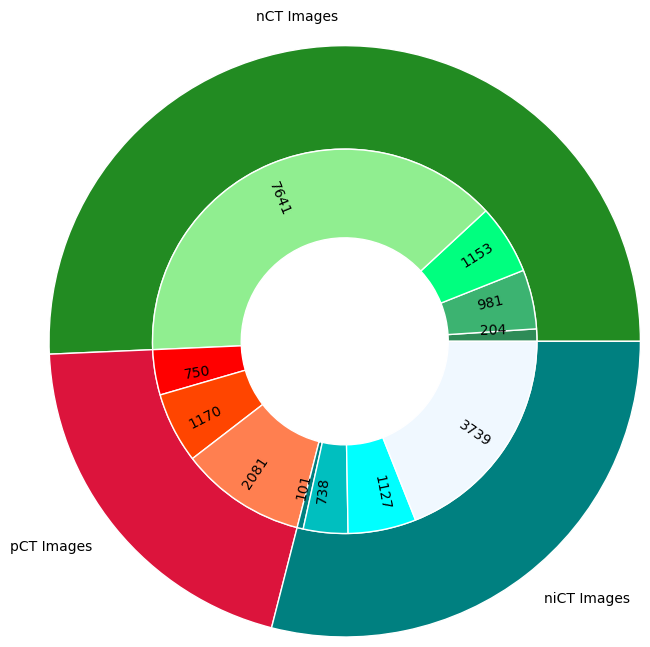

In [ ]:
# Showing a pie chart of the all the images, sorted by image class type and including the break down of image dimensions within each class
nCT_count = sum(nCT_dim.values())
pCT_count = sum(pCT_dim.values())
niCT_count = sum(niCT_dim.values())

nct_counts = natsorted(list(nCT_dim.values()))
pct_counts = natsorted(list(pCT_dim.values()))
nict_counts = natsorted(list(niCT_dim.values()))


outer_colors = [nCT_count, pCT_count, niCT_count]
inner_colors = [nct_counts, pct_counts, nict_counts]

# Putting all the values from the inner_colors sublists into one continuous list
inner_colors_flattened = [item for sublist in inner_colors for item in sublist]


fig, axs = plt.subplots()

# Outer pie chart
axs.pie(outer_colors, radius=2, colors=['forestgreen','crimson','teal'],
       wedgeprops=dict(width=0.7, edgecolor='w'), labels=['nCT Images', 'pCT Images', 'niCT Images'], labeldistance=1.1)

# Inner pie chart
axs.pie(inner_colors_flattened, radius=1.3, colors=['seagreen','mediumseagreen','springgreen','lightgreen','red','orangered','coral','teal','c','aqua','aliceblue'],
       wedgeprops=dict(width=0.6, edgecolor='w'), labels=inner_colors_flattened, labeldistance=0.7, rotatelabels=True)


# Show the plot
plt.show()

## Viewing images, channels and inspecting channel differences <div id='differences'>

It is important to get a visual understanding of the data that we will be handling for this notebook. We note that each CT image from the negative/positive images very clearly shows a crossectional image of the human lungs. The non-informative image shows extraneous portions of the body, and would be of no interest to a physician looking to analyse the condition of their patient.

Likewise, we use this section to test if there is any additional data in those separate channels by subtracting each channel from each other and searching for any differences in the resulting image.

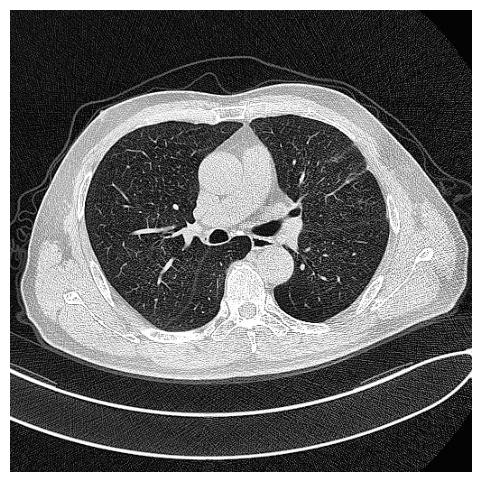

In [ ]:
# Viewing the first image with all three channels on
nCT_processed = exposure.equalize_adapthist(nCT[0])
plt.figure(figsize=(6, 6))
plt.imshow(nCT_processed)
plt.axis('off')
plt.show()

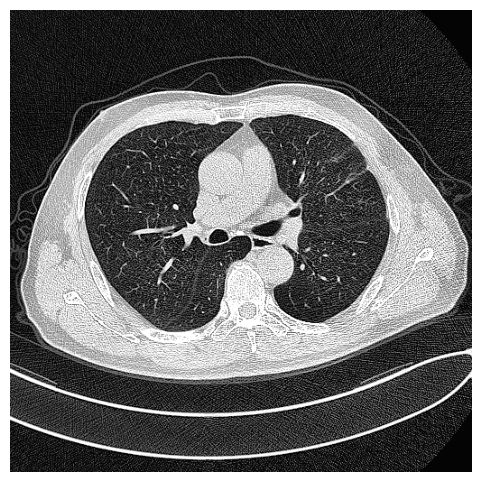

In [ ]:
# Viewing the first on only one channel
nCT_processed = exposure.equalize_adapthist(nCT[0][:,:,0])
plt.figure(figsize=(6, 6))
plt.imshow(nCT_processed, cmap='gray')
plt.axis('off')
plt.show()

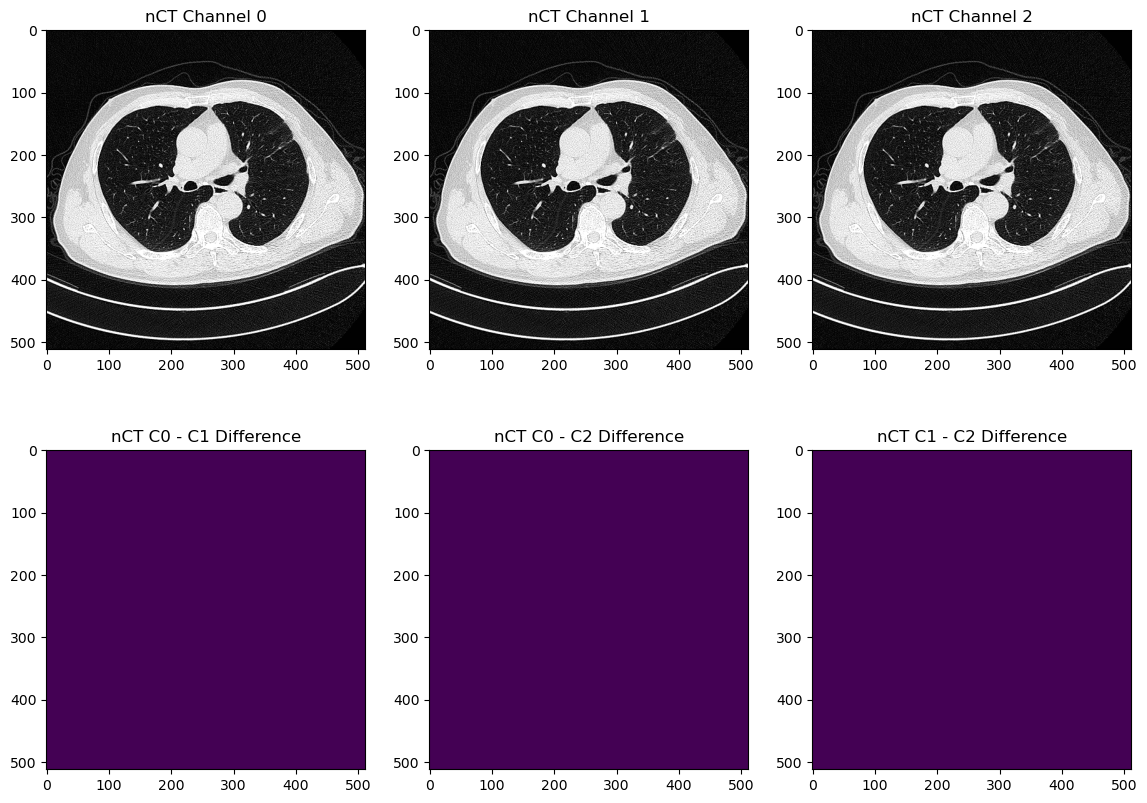

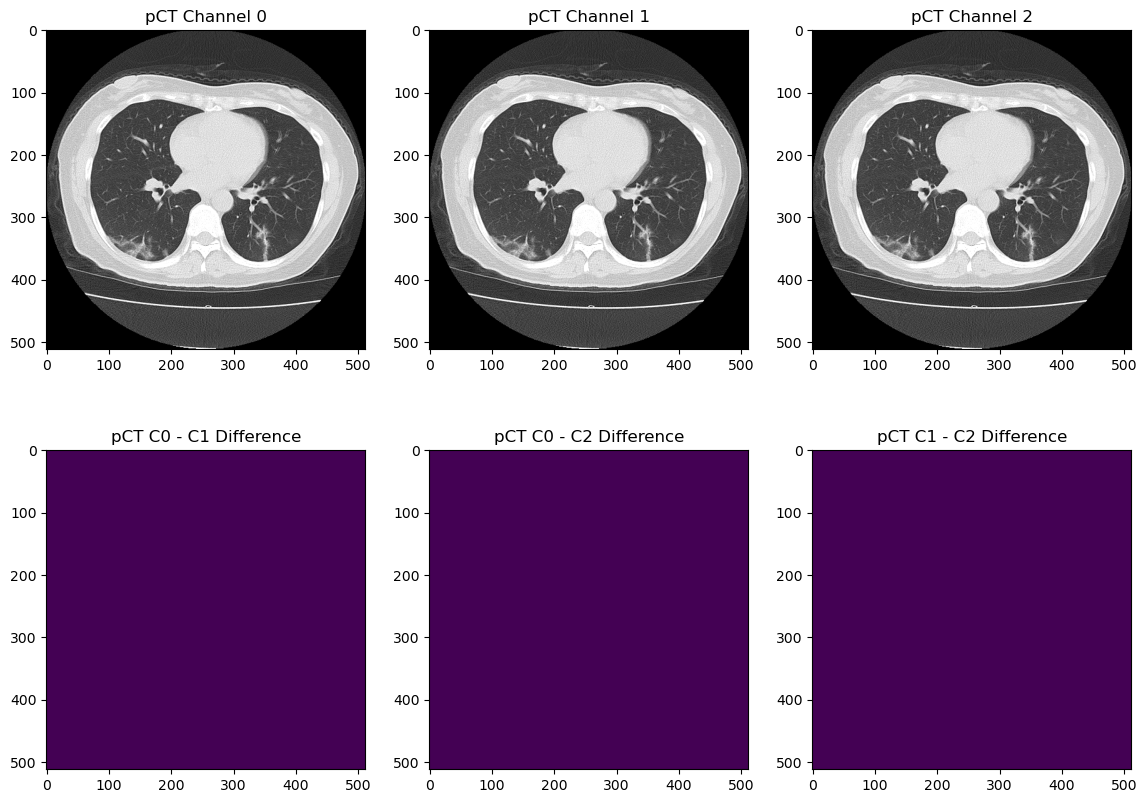

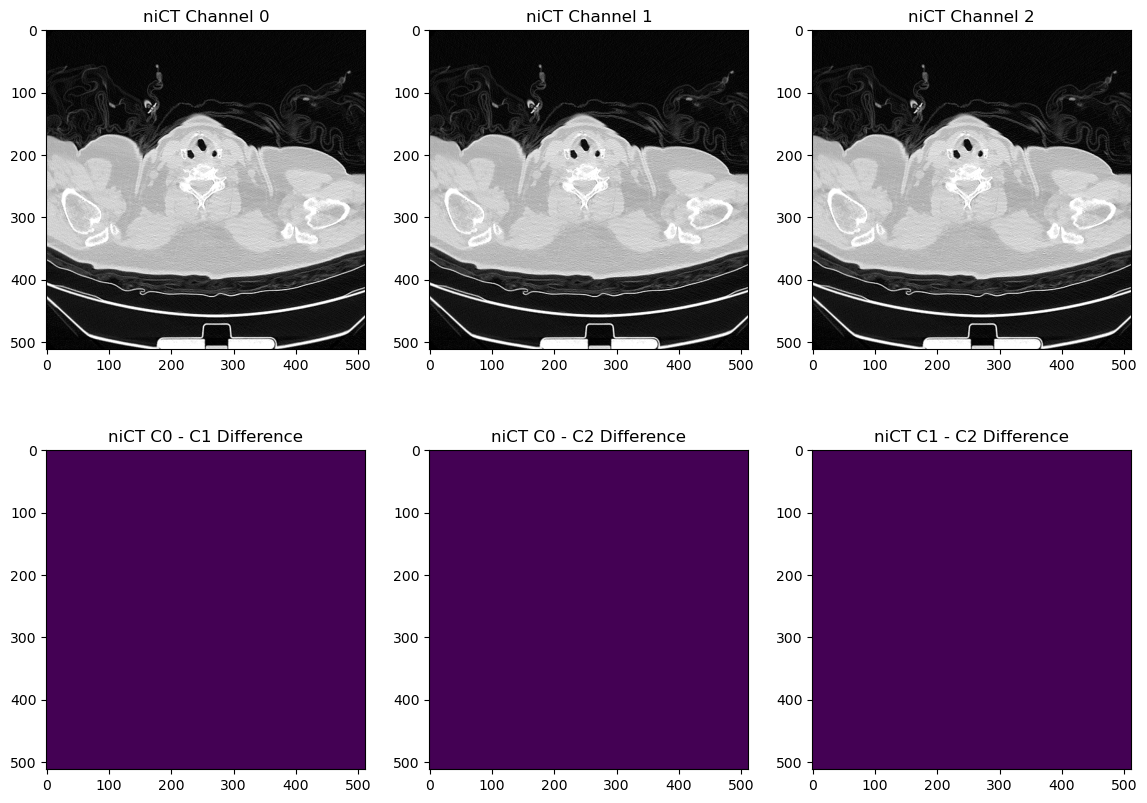

In [ ]:
# Inspecting the three channels individually
def plot_3_color_channels(img, img_class):
    '''Function plots the three color channels of the image along with the channel differences'''
    fig, ax = plt.subplots(2,3, figsize=(14, 10))
    ax = ax.flatten()
    ## Complete the code below
    titles=['Channel 0','Channel 1','Channel 2','C0 - C1 Difference','C0 - C2 Difference','C1 - C2 Difference']
    for i in range(3):
        ax[i].imshow(img[:,:,i], cmap=plt.get_cmap('gray'))
        ax[i].set_title(img_class+titles[i])
    ax[3].imshow(img[:,:,0] - img[:,:,1])
    ax[3].set_title(img_class+titles[3])
    ax[4].imshow(img[:,:,0] - img[:,:,2])
    ax[4].set_title(img_class+titles[4])
    ax[5].imshow(img[:,:,1] - img[:,:,2])
    ax[5].set_title(img_class+titles[5])

plot_3_color_channels(nCT[0],'nCT ')
plot_3_color_channels(pCT[0],'pCT ')
plot_3_color_channels(niCT[0],'niCT ')

## Pixel Distributions <div id='distributions'>

Checking the distribution of pixels across the three image classification types for any irregularities. We find that the target with which we are interested in is fairly well distributed, ignoring the black background.

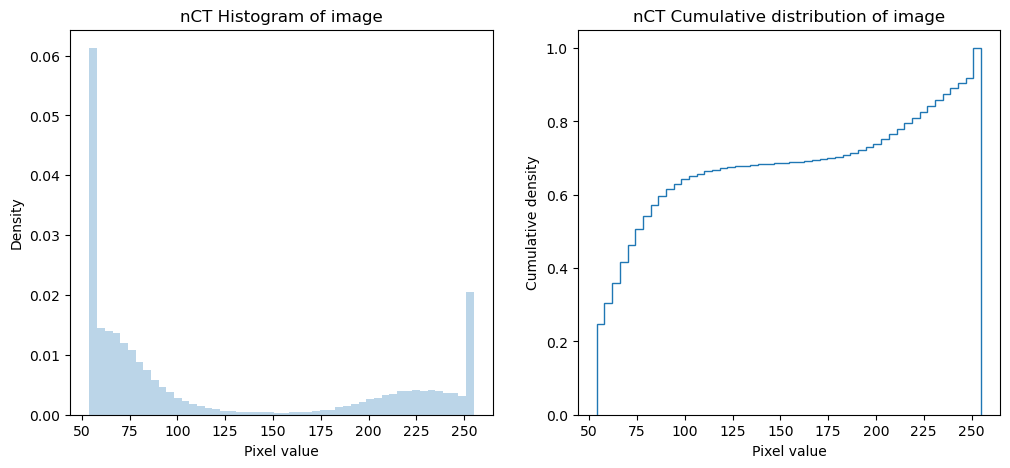

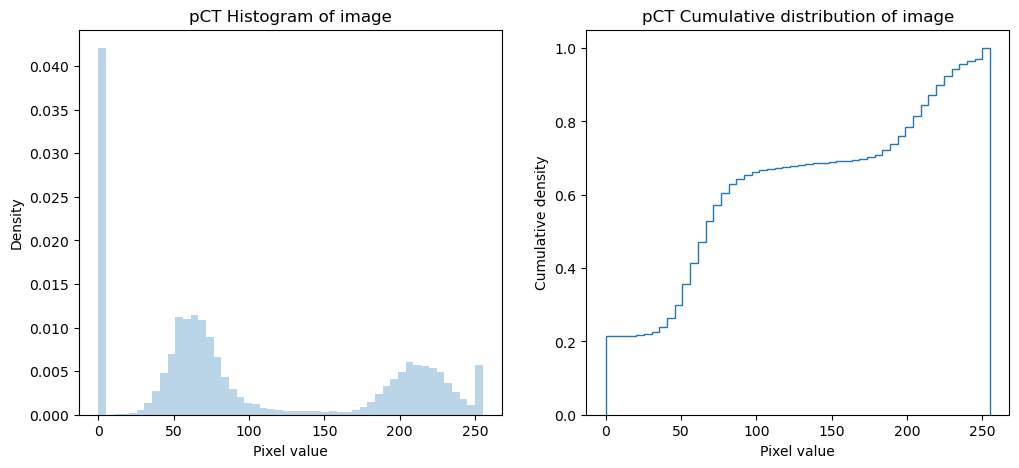

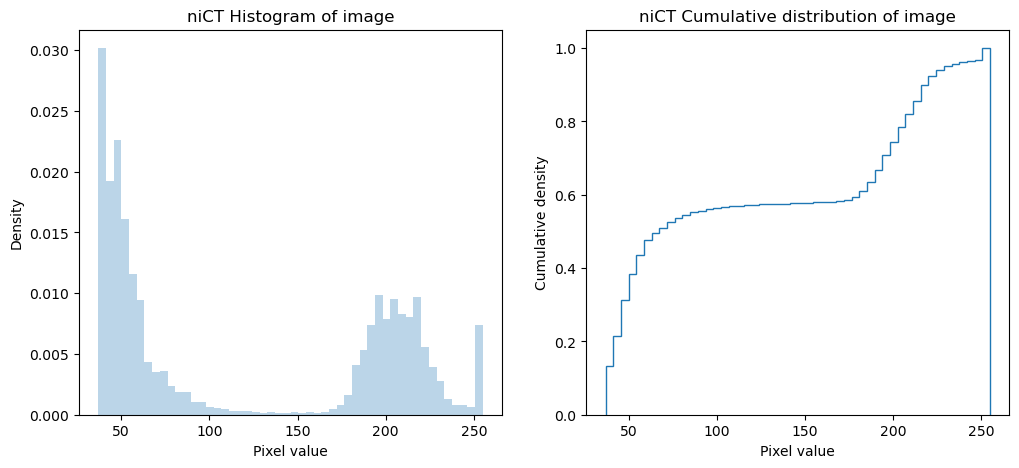

In [ ]:
# Observing pixel intensity distribution
def plot_gray_scale_distribution(img, img_class):
    '''Function plots histograms a gray scale image along
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title(f'{img_class} Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')
    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title(f'{img_class} Cumulative distribution of image')
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density')
    plt.show()

plot_gray_scale_distribution(nCT[0],'nCT')
plot_gray_scale_distribution(pCT[0],'pCT')
plot_gray_scale_distribution(niCT[0],'niCT')

## EDA Conclusions <div id='eda_conclusions'>
Initial conclusions: We note that there is a mix of image dimensions in the dataset which will require rescaling during the pre-processing.

From our first viewing of the image, we can see that we have what is technically a black and white image, with one channel that has been copied over to the other 2. We can therefore disregard the 3 channel dimensions and drop 2 of the channels as they do not contain any new information.

# Image Pre-Processing <div id='preprocessing'>

For preprocessing, we aim to recreate the processed images that were provided with the original dataset. This is done as an exercise in proper pre-processing techniques as well as to verify that what I have done in this notebook aligns closely to that of the researchers. We start by first resizing all images to be a uniform 512x512 resoltion, followed by the removal of the extraneous 2 channels. This leaves us with a proper grayscale image that can then be further processed.

Processing is done in the form of feature extraction. A rough overview of the process is shown below. In order to process all images, this had to be done in stages by loading and saving the images several times. This was done as the system would often run out of memory if all images were to be processed at once.

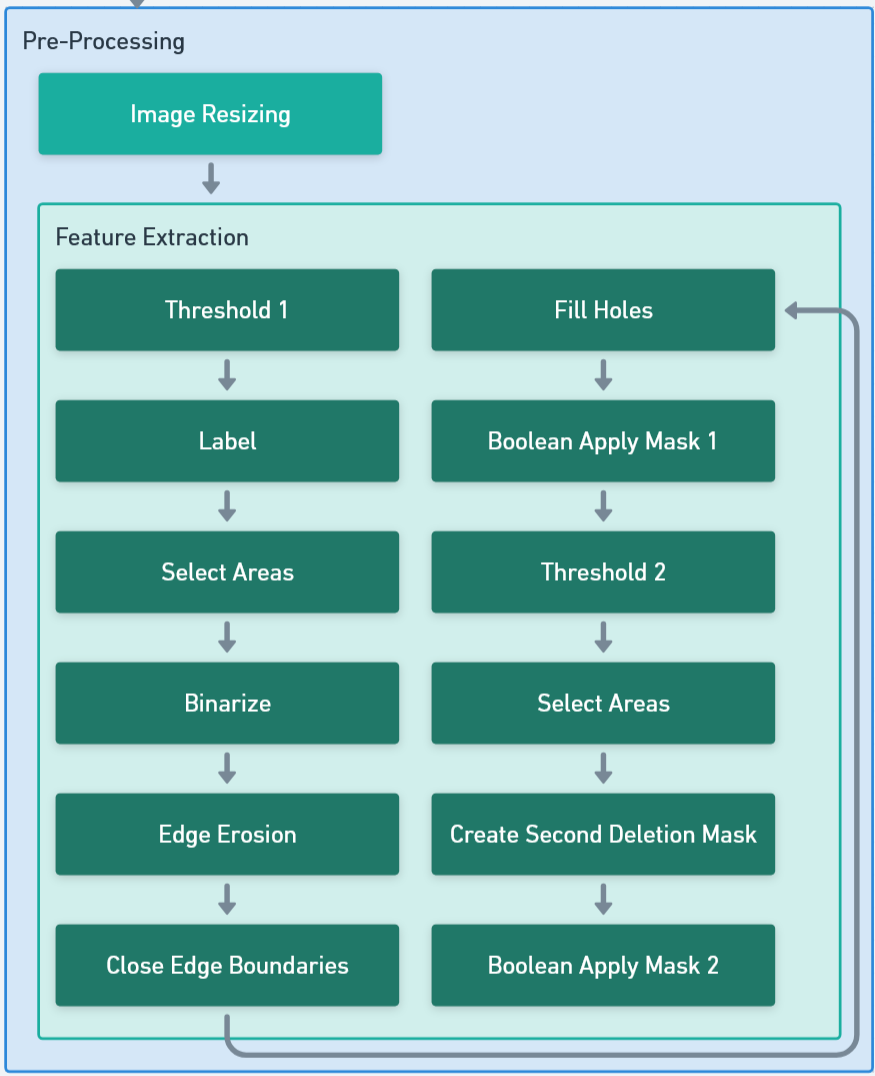

This is able to effectively extract the lung features from the images, allowing the models to train on only identifying whether or not there is a lung in the image, and if it is, whether or not it has COVID-19 Pneumonia. Once completed, the notebook was reset and only the modified images were loaded back in as to lower total system memory usage.

In [ ]:
# First, resizing the images to all be uniform 512 x 512
processed_dir = './data/processed/'

resized_dim = (512, 512)

def resize_images(imgs):
    resized = []
    for img in imgs:
        img = Image.fromarray(img)
        if img.size[0] > resized_dim[0] or img.size[1] > resized_dim[1]:
            resized.append(img.resize(resized_dim))

        else:
            resized.append(img)

    return resized

nCT = resize_images(nCT)
pCT = resize_images(pCT)
niCT = resize_images(niCT)

In [ ]:
# Saving all images, restarting notebook to save GPU Memory
for i in range(len(nCT)):
    nCT[i].save(f"{processed_dir}nCT/nCT{i}.jpg")

for i in range(len(pCT)):
    pCT[i].save(f"{processed_dir}pCT/pCT{i}.jpg")

for i in range(len(niCT)):
    niCT[i].save(f"{processed_dir}niCT/niCT{i}.jpg")

In [ ]:
# Restarting notebook and proceeding with image preprocessing

In [ ]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_erosion, binary_closing, dilation
from skimage.filters import threshold_local
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi
from skimage import measure

def pre_process(img):
    # Apply local thresholding
    thresh = ((img > threshold_local(img, block_size=401)) * 255).astype(np.uint8)

    # Label connected regions
    label_image = label(thresh, connectivity=1)

    # Get areas of labeled regions
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()

    # Remove small regions
    if areas:
        min_area = areas[0]
        for region in regionprops(label_image):
            if region.area < min_area:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0

    # Create binary image
    binary = label_image > 0

    # Apply morphological operations
    binary = binary_erosion(binary, disk(4))
    binary = binary_closing(binary, disk(6))  # Change back to 10 if needed

    # Detect edges
    edges = roberts(binary)

    # Fill holes in binary image
    binary = ndi.binary_fill_holes(edges)

    # Get high values
    get_high_vals = binary == 0

    # Mask high values in the original image
    img_c = img * ~get_high_vals.astype(bool)

    # Label regions in the thresholded image
    img_test = measure.label(thresh, connectivity=1)
    props = measure.regionprops(img_test)
    areas = [prop.area for prop in props]

    # Find the largest region
    ind_max_area = np.argmax(areas) + 1
    del_array = np.zeros(img_test.max() + 1)
    del_array[ind_max_area] = 1
    del_mask = del_array[img_test]

    # Mask the largest region in the original image
    img_c = img_c * ~del_mask.astype(bool)

    return img_c

In [ ]:
# Load data
nct_files = natsorted(os.listdir('./data/processed/nCT'))
nCT = []
for i in range(len(nct_files)):
    nCT.append(io.imread(f'./data/processed/nCT/nCT{i}.jpg', as_gray=True))

# Verify dimensions
nCT_dim = count_dimensions(nCT)
for dims, count in nCT_dim.items():
    print(f"Dimensions: {dims}, Count: {count}")

Dimensions: (512, 512), Count: 9979


In [ ]:
# pre-process
nCT_proc = [pre_process(img) for img in nCT]

In [ ]:
# save images
for i, img in enumerate(nCT_proc):
    path = "./data/processed/nCT_p/nCT_p"+str(i+1)+".jpg"
    cv2.imwrite(path, img * 255)

In [ ]:
# Reset Kernel to clear memory and perform next series of cells

In [ ]:
# Load data
pct_files = natsorted(os.listdir('./data/processed/pCT'))
pCT = []
for i in range(len(pct_files)):
    pCT.append(io.imread(f'./data/processed/pCT/pCT{i}.jpg', as_gray=True))

# Verify dimensions
pCT_dim = count_dimensions(pCT)
for dims, count in pCT_dim.items():
    print(f"Dimensions: {dims}, Count: {count}")

Dimensions: (512, 512), Count: 4001


In [ ]:
# pre-process
pCT_proc = [pre_process(img) for img in pCT]

In [ ]:
# save
for i, img in enumerate(pCT_proc):
    path = "./data/processed/pCT_p/pCT_p"+str(i+1)+".jpg"
    cv2.imwrite(path, img * 255)

In [ ]:
# Reset Kernel to clear memory and perform next series of cells

In [ ]:
# Load data
nict_files = natsorted(os.listdir('./data/processed/niCT'))
niCT = []
for i in range(len(nict_files)):
    niCT.append(io.imread(f'./data/processed/niCT/niCT{i}.jpg', as_gray=True))

# Verify dimensions
niCT_dim = count_dimensions(niCT)
for dims, count in niCT_dim.items():
    print(f"Dimensions: {dims}, Count: {count}")

Dimensions: (512, 512), Count: 5705


In [ ]:
# pre-process
niCT_proc = [pre_process(img) for img in niCT]

In [ ]:
# save
for i, img in enumerate(niCT_proc):
    path = "./data/processed/niCT_p/niCT_p"+str(i+1)+".jpg"
    cv2.imwrite(path, img * 255)

In [ ]:
# Final restart and reloading all final, pre-processed data
# img_dir = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/data/processed/'
img_dir = './data/processed/'

nCT = []
pCT = []
niCT = []
nct_files = natsorted(os.listdir(img_dir + 'nCT_p'))
pct_files = natsorted(os.listdir(img_dir + 'pCT_p'))
nict_files = natsorted(os.listdir(img_dir + 'niCT_p'))
for i in range(len(nct_files)):
    nCT.append(io.imread(f'{img_dir}nCT_p/nCT_p{i}.jpg', as_gray=True))

for i in range(len(pct_files)):
    pCT.append(io.imread(f'{img_dir}pCT_p/pCT_p{i}.jpg', as_gray=True))

for i in range(len(nict_files)):
    niCT.append(io.imread(f'{img_dir}niCT_p/niCT_p{i}.jpg', as_gray=True))

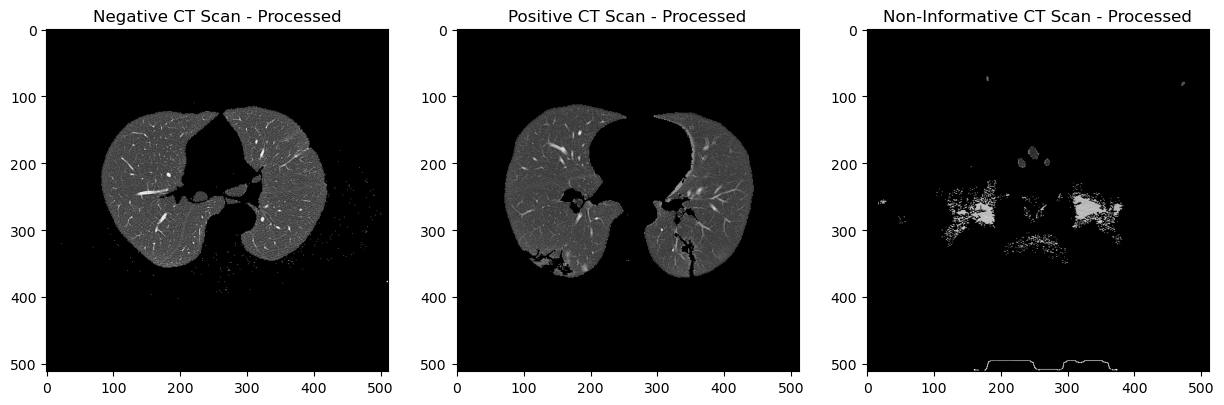

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 15))
axs[0].imshow(nCT[1], cmap='gray')
axs[0].set_title('Negative CT Scan - Processed')
axs[1].imshow(pCT[1], cmap='gray')
axs[1].set_title('Positive CT Scan - Processed')
axs[2].imshow(niCT[1], cmap='gray')
axs[2].set_title('Non-Informative CT Scan - Processed')

plt.show()

# Data Augmentaion and Pipeline <div id='aug_pipeline'>

In order to resolve the data class imbalance in the dataset, I had to generate additional images in order to even out the classifications and prevent any potential learning biases. I utilized data augmentation in order to further enhance the generated dataset, applying slight rotation and translation to the images. No shearing, flipping, zooming or rescaling could be used for these images as they are of a medical nature. There are certain proportions and positionally important features that cannot be altered, otherwise the physiology of the human body would be incorrect, and thusly invalidate any findings that the models might have.

Post augmentation, the data pipeline is established. We concatenate the three classes of images together and create an additional array, containing class labels, which the model will attempt to classify. These are then split into a training, validation and testing split with a 70/20/10 ratio. I opt for this type of a data split as I wish to test each model on a completely out-of-sample dataset in order to verify it's performance. Once complete, we can then create tensorflow datasets which can then be batched, shuffled, and prefetched for the training and testing.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_images = 9000

# Defining the image generator
datagen = ImageDataGenerator(
    rotation_range=15, # Degree range for random rotations
    width_shift_range=0.1, # Range for random horizontal shifts
    height_shift_range=0.1, # Range for random vertical shifts
)

# Function for adding in extra images in order to deal with data imbalance
def generate_img(imgs, target):
    existing = len(imgs)
    needed = target - existing
    extra = []

    i = 0
    for batch in datagen.flow(np.expand_dims(imgs, axis=(-1)), batch_size=1):

        batch = np.squeeze(batch, axis=0)
        # Convert back to uint8
        batch = batch.astype(np.uint8)
        extra.append(batch)
        i += 1

        if i >= needed:
            break

    imgs = np.expand_dims(imgs, axis=-1)
    return np.concatenate([imgs, np.array(extra)])

# nCT = generate_img(nCT, num_images)
pCT = generate_img(pCT, num_images)
niCT = generate_img(niCT, num_images)

# Converting everything to numpy arrays
nCT = np.array(nCT)
pCT = np.array(pCT)
niCT = np.array(niCT)

# Creating labels needed for classification
nCT_labels = np.zeros((nCT.shape[0],))
pCT_labels = np.ones((pCT.shape[0],))
niCT_labels = 2*np.ones((niCT.shape[0],))

# Removing extra dimension added by the datagen
pCT = np.squeeze(pCT, axis=-1)
niCT = np.squeeze(niCT, axis=-1)

In [ ]:
# Creating singular datasets
X = np.concatenate((nCT, pCT, niCT))
y = np.concatenate((nCT_labels, pCT_labels, niCT_labels))

In [ ]:
from sklearn.model_selection import train_test_split

# Creating a train, validate, test split of 70/20/10
# First creating the train and test splits
X_train_split, X_test, y_train_split, y_test = train_test_split(X, y, test_size = 0.1, random_state=25, stratify=y)

# Next creating the train and validation splits
X_train, X_val, y_train, y_val = train_test_split(X_train_split, y_train_split, test_size=0.2/0.9, random_state=25, stratify=y_train_split)

In [ ]:
# X_train = np.load(f'{img_dir}X_train.npy')
# y_train = np.load(f'{img_dir}y_train.npy')
# X_val = np.load(f'{img_dir}X_val.npy')
# y_val = np.load(f'{img_dir}y_val.npy')
X_test = np.load(f'{img_dir}X_test.npy') # will import after training
y_test = np.load(f'{img_dir}y_test.npy') # will import after training

In [ ]:
# Making dataset objects
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # will import after training

# Shuffling, batching and prefetching the data
batch_size = 16
# train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size=len(X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=len(X_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE) # will import after training

# Training Existing Model Architectures <div id="training">

The initial code cell is used to initialize all necessary libraries and functions needed for the successful creation of all the models which will be trained and tested. For all models a custom top was created. It consists of global average pooling 2D, batch normalization, and dropout before finally being passed through the output dense layer. A softmax activation is used as we are trying to perform a multi-class classification with the models.

Additional functions include a checkpoint callback in order to retrieve weights at the end of training. These weights will be loaded back in later when performing model testing on the test datasets, as keeping all models loaded is not pheasable without exorbitant amounts of VRAM. Likewise, there is a history plotting function in order to visualize the training progress once training has completed. Early stopping was initially used, however some models struggled with initial epochs and therefore it was decided to let all models run for 10 epochs and test their capabilities based off of the final model weights.

### Models trained:
- EfficientNetV2B0
- EfficientNetV2B1
- EfficientNetV2B2
- ConvNeXtTiny
- ConvNeXtSmall
- ConvNeXtBase
- ResNet50V2
- ResNet101V2
- ResNet152V2

Further training was briefly considered, however due to resource constraints were not possible at this time.

Smaller were trained on local machine with an Intel 13700k CPU running at 5GHz, 64GB RAM, and a RTX 4090 GPU with 24GB VRAM. Larger models were trained on Google Colab using an A100 with 40GB of VRAM.

These three models were chosen for their continued relevance in the CV space as well as looking at the advancements in architecture performance over the years. ResNetV2 is the oldest architecture of the models tested here, being developed in 2016, roughly 8 years ago. More modern are the ConvNeXt (2022) and EfficientNetV2 (2021) architectures. My hypothesis is that the more modern models will be able to better classify the images into their respective categories will little error.

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2
from tensorflow.keras.applications import ConvNeXtTiny, ConvNeXtSmall, ConvNeXtBase, ResNet50V2
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.experimental import AdamW
from keras import layers
import keras

def make_model_top(base_model, model_name):
    model = Sequential(name=model_name)
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    top_dropout_rate = 0.2
    model.add(layers.Dropout(top_dropout_rate, name="top_dropout"))
    model.add(layers.Dense(3, activation='softmax'))
    return model

def callbacks(filepath):

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=False)

    return checkpoint

def plot_hist(hist):
    _,ax = plt.subplots(1,2, figsize = (12,6))
    ax[0].plot(hist.history["accuracy"])
    ax[0].plot(hist.history["val_accuracy"])
    ax[0].set_title("model accuracy")
    ax[0].set_ylabel("accuracy")
    ax[0].set_xlabel("epoch")
    ax[0].legend(["train", "validation"], loc="upper left")
    ax[1].plot(hist.history["loss"])
    ax[1].plot(hist.history["val_loss"])
    ax[1].set_title("model loss")
    ax[1].set_ylabel("loss")
    ax[1].set_xlabel("epoch")
    ax[1].legend(["train", "validation"], loc="upper right")
    plt.show()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the number of epochs
training_epochs = 10

In [ ]:
# Create the B0 Base Model
base_model = EfficientNetV2B0(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

EffNetV2B0 = make_model_top(base_model, "EfficientNetV2B0")
# Compile the model
EffNetV2B0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Reloading weights at a later point
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/efficientnetv2b0_checkpoint'
EffNetV2B0.load_weights(filepath, skip_mismatch=False)

In [ ]:
EffNetV2B0.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 16, 16, 1280)      5918736   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                  

Epoch 1/10


2024-05-06 09:45:03.127078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2B0/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


613/613 [==============================] - 131s 181ms/step - loss: 0.4537 - accuracy: 0.8401 - val_loss: 0.1892 - val_accuracy: 0.9430
Epoch 2/10
613/613 [==============================] - 113s 184ms/step - loss: 0.2372 - accuracy: 0.9288 - val_loss: 0.1650 - val_accuracy: 0.9482
Epoch 3/10
613/613 [==============================] - 113s 185ms/step - loss: 0.2695 - accuracy: 0.9176 - val_loss: 0.2663 - val_accuracy: 0.9219
Epoch 4/10
613/613 [==============================] - 114s 187ms/step - loss: 0.2014 - accuracy: 0.9371 - val_loss: 0.0936 - val_accuracy: 0.9707
Epoch 5/10
613/613 [==============================] - 114s 186ms/step - loss: 0.1603 - accuracy: 0.9502 - val_loss: 0.1063 - val_accuracy: 0.9623
Epoch 6/10
613/613 [==============================] - 114s 187ms/step - loss: 0.1406 - accuracy: 0.9568 - val_loss: 0.0924 - val_accuracy: 0.9734
Epoch 7/10
613/613 [==============================] - 113s 185ms/step - loss: 0.0848 - accuracy: 0.9721 - val_loss: 0.0681 - val_accura

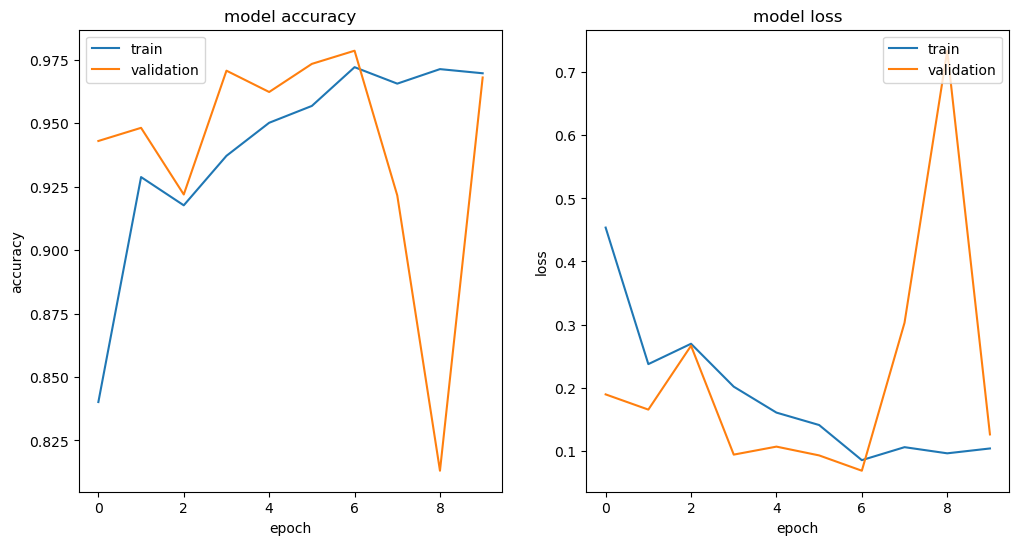

In [ ]:
# Checkpointing
V2B0_cp = callbacks('efficientnetv2b0_checkpoint')

# Fit the model
EffNetV2B0_hist = EffNetV2B0.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[V2B0_cp, early_stopping]
)

# Plot training history
plot_hist(EffNetV2B0_hist)

In [ ]:
# Create the B1 Base Model
base_model = EfficientNetV2B1(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

EffNetV2B1 = make_model_top(base_model, "EfficientNetV2B1")
# Compile the model
EffNetV2B1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/efficientnetv2b1_checkpoint'
EffNetV2B1.load_weights(filepath, skip_mismatch=False)

In [ ]:
EffNetV2B1.summary()

Model: "EfficientNetV2B1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Functio  (None, 16, 16, 1280)      6930548   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                  

Epoch 1/10


2024-05-06 10:10:02.753887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2B1/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-06 10:10:04.148754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-06 10:10:04.221652: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-06 10:10:04.436181: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-06 10:10:05.946803: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0ab8316a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 10:10:05.946826: I external/local_xla/xla/service/service.cc:176]   StreamExecutor devi

613/613 [==============================] - 183s 246ms/step - loss: 0.4758 - accuracy: 0.8239 - val_loss: 0.8408 - val_accuracy: 0.7550
Epoch 2/10
613/613 [==============================] - 145s 237ms/step - loss: 0.2787 - accuracy: 0.9142 - val_loss: 0.1659 - val_accuracy: 0.9507
Epoch 3/10
613/613 [==============================] - 142s 232ms/step - loss: 0.1891 - accuracy: 0.9386 - val_loss: 0.1445 - val_accuracy: 0.9575
Epoch 4/10
613/613 [==============================] - 142s 232ms/step - loss: 0.2213 - accuracy: 0.9350 - val_loss: 0.9346 - val_accuracy: 0.7475
Epoch 5/10
613/613 [==============================] - 142s 231ms/step - loss: 0.1962 - accuracy: 0.9385 - val_loss: 0.1449 - val_accuracy: 0.9464
Epoch 6/10
613/613 [==============================] - 142s 231ms/step - loss: 0.1472 - accuracy: 0.9503 - val_loss: 0.0775 - val_accuracy: 0.9703
Epoch 7/10
613/613 [==============================] - 142s 231ms/step - loss: 0.1756 - accuracy: 0.9465 - val_loss: 0.1562 - val_accura

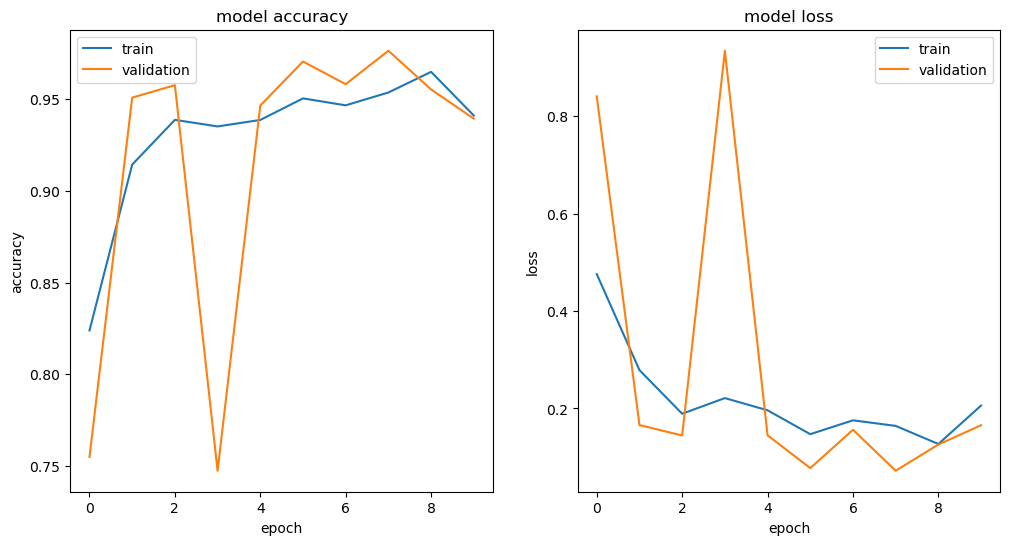

In [ ]:
# Checkpointing
V2B1_cp = callbacks('efficientnetv2b1_checkpoint')

# Fit the model
EffNetV2B1_hist = EffNetV2B1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[V2B1_cp, early_stopping]
)

# Plot training history
plot_hist(EffNetV2B1_hist)

In [ ]:
# Create the B2 Base Model
base_model = EfficientNetV2B2(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

EffNetV2B2 = make_model_top(base_model, "EfficientNetV2B2")
# Compile the model
EffNetV2B2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/efficientnetv2b2_checkpoint'
EffNetV2B2.load_weights(filepath, skip_mismatch=False)

In [ ]:
EffNetV2B2.summary()

Model: "EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 16, 16, 1408)      8768798   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1408)              5632      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 3)                 4227      
                                                  

Epoch 1/10
307/307 [==============================] - 246s 559ms/step - loss: 0.4423 - accuracy: 0.8399 - val_loss: 0.6116 - val_accuracy: 0.7432
Epoch 2/10
307/307 [==============================] - 166s 541ms/step - loss: 0.2396 - accuracy: 0.9207 - val_loss: 2.5680 - val_accuracy: 0.4544
Epoch 3/10
307/307 [==============================] - 166s 541ms/step - loss: 0.3001 - accuracy: 0.8944 - val_loss: 0.2511 - val_accuracy: 0.9119
Epoch 4/10
307/307 [==============================] - 166s 542ms/step - loss: 0.1881 - accuracy: 0.9423 - val_loss: 0.1425 - val_accuracy: 0.9505
Epoch 5/10
307/307 [==============================] - 166s 542ms/step - loss: 0.1350 - accuracy: 0.9549 - val_loss: 0.1563 - val_accuracy: 0.9396
Epoch 6/10
307/307 [==============================] - 166s 542ms/step - loss: 0.1524 - accuracy: 0.9514 - val_loss: 0.0949 - val_accuracy: 0.9648
Epoch 7/10
307/307 [==============================] - 166s 541ms/step - loss: 0.1508 - accuracy: 0.9540 - val_loss: 0.0951 -

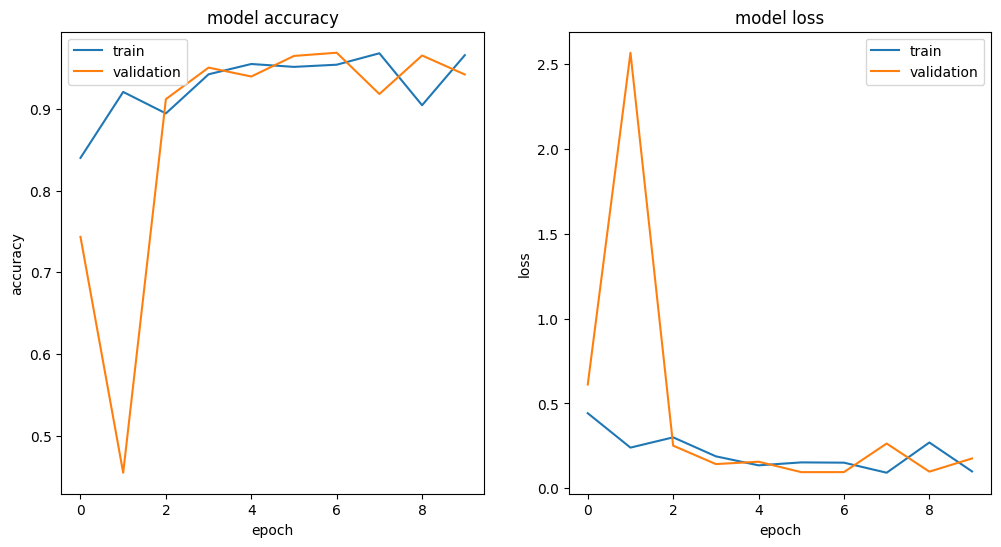

In [ ]:
# Checkpointing
V2B2_cp = callbacks('efficientnetv2b2_checkpoint')

# Fit the model
EffNetV2B2_hist = EffNetV2B2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[V2B2_cp, early_stopping]
)

# Plot training history
plot_hist(EffNetV2B2_hist)

In [ ]:
# Create the ConvNeXtTiny Base Model
base_model = ConvNeXtTiny(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

CNTiny = make_model_top(base_model, "EfficientNetV2B3")
# Compile the model
CNTiny.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/efficientnetv2b3_checkpoint'
CNTiny.load_weights(filepath, skip_mismatch=False)

In [ ]:
CNTiny.summary()

Model: "EfficientNetV2B3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 16, 16, 768)       27817056  
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (None, 768)               0         
                                                                 
 dense (Dense)               (None, 3)                 2307      
                                                                 
Total params: 27822435 (106.13 MB)
Trainable param

Epoch 1/10
613/613 [==============================] - 506s 760ms/step - loss: 0.5692 - accuracy: 0.7744 - val_loss: 6.2184 - val_accuracy: 0.3217
Epoch 2/10
613/613 [==============================] - 455s 742ms/step - loss: 0.4347 - accuracy: 0.8284 - val_loss: 39.8267 - val_accuracy: 0.3567
Epoch 3/10
613/613 [==============================] - 455s 742ms/step - loss: 0.3213 - accuracy: 0.8866 - val_loss: 16.1265 - val_accuracy: 0.3570
Epoch 4/10
613/613 [==============================] - 455s 742ms/step - loss: 0.2443 - accuracy: 0.9156 - val_loss: 1.3747 - val_accuracy: 0.6346
Epoch 5/10
613/613 [==============================] - 455s 742ms/step - loss: 0.2011 - accuracy: 0.9301 - val_loss: 6.6484 - val_accuracy: 0.5781
Epoch 6/10
613/613 [==============================] - 455s 742ms/step - loss: 0.1713 - accuracy: 0.9418 - val_loss: 7.9611 - val_accuracy: 0.6074
Epoch 7/10
613/613 [==============================] - 455s 742ms/step - loss: 0.1497 - accuracy: 0.9474 - val_loss: 0.3504

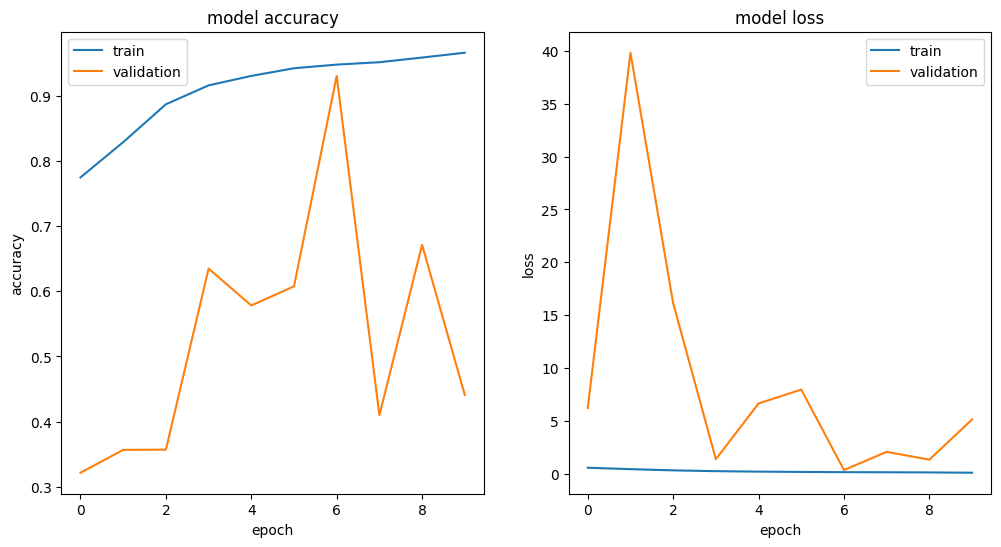

In [ ]:
# Checkpointing
CNTiny_cp = callbacks('efficientnetv2b3_checkpoint')

# Fit the model
CNTiny_hist = CNTiny.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[CNTiny_cp, early_stopping]
)

# Plot training history
plot_hist(CNTiny_hist)

In [ ]:
# Create the ConvNeXtSmall Base Model
base_model = ConvNeXtSmall(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

CNSmall = make_model_top(base_model, "ConvNeXtSmall")
# Compile the model
CNSmall.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/convnextsmall_checkpoint'
CNSmall.load_weights(filepath, skip_mismatch=False)

In [ ]:
CNSmall.summary()

Model: "ConvNeXtSmall"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_small (Functional  (None, 16, 16, 768)       49451616  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 768)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (None, 768)               0         
                                                                 
 dense (Dense)               (None, 3)                 2307      
                                                     

Epoch 1/10
1225/1225 [==============================] - 910s 686ms/step - loss: 0.4967 - accuracy: 0.8260 - val_loss: 4.1770 - val_accuracy: 0.4507
Epoch 2/10
1225/1225 [==============================] - 823s 672ms/step - loss: 0.3539 - accuracy: 0.8796 - val_loss: 0.3560 - val_accuracy: 0.8999
Epoch 3/10
1225/1225 [==============================] - 823s 672ms/step - loss: 0.2608 - accuracy: 0.9158 - val_loss: 4.3764 - val_accuracy: 0.5515
Epoch 4/10
1225/1225 [==============================] - 823s 672ms/step - loss: 0.1991 - accuracy: 0.9340 - val_loss: 3.6421 - val_accuracy: 0.5139
Epoch 5/10
1225/1225 [==============================] - 823s 672ms/step - loss: 0.1762 - accuracy: 0.9397 - val_loss: 0.3190 - val_accuracy: 0.9008
Epoch 6/10
1225/1225 [==============================] - 824s 672ms/step - loss: 0.1441 - accuracy: 0.9514 - val_loss: 1.5435 - val_accuracy: 0.5502
Epoch 7/10
1225/1225 [==============================] - 823s 672ms/step - loss: 0.1341 - accuracy: 0.9559 - val_

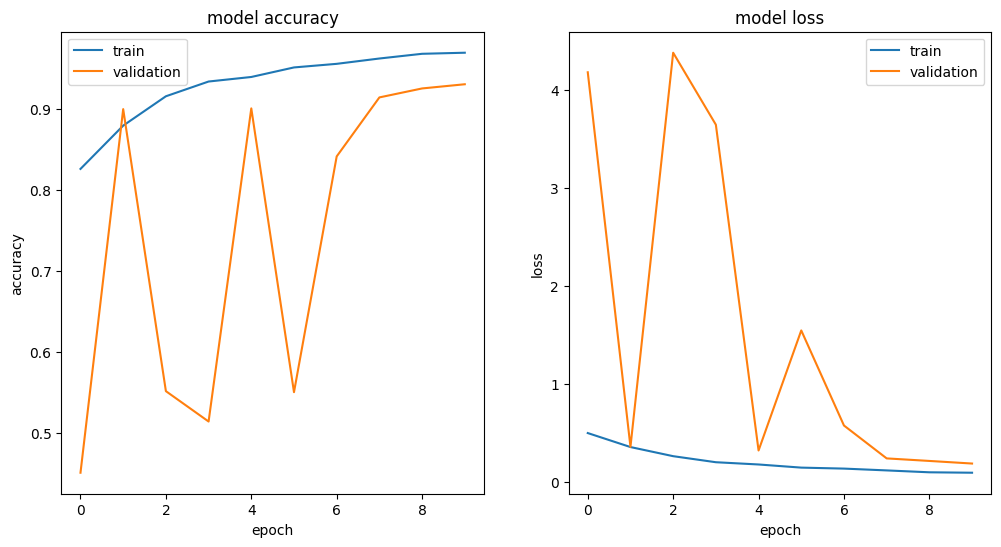

In [ ]:
# Checkpointing
CNSmall_cp = callbacks('convnextsmall_checkpoint')

# Fit the model
CNSmall_hist = CNSmall.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[CNSmall_cp, early_stopping]
)

# Plot training history
plot_hist(CNSmall_hist)

In [ ]:
# Create the ConvNeXtBase Base Model
base_model = ConvNeXtBase(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

CNBase = make_model_top(base_model, "ConvNeXtBase")
# Compile the model
CNBase.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/convnextbase_checkpoint'
CNBase.load_weights(filepath, skip_mismatch=False)

In [ ]:
CNBase.summary()

Model: "ConvNeXtBase"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 16, 16, 1024)      87562368  
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 87569539 (334.05 MB)
Trainable params: 8

Epoch 1/10
1633/1633 [==============================] - 1325s 769ms/step - loss: 0.5541 - accuracy: 0.8022 - val_loss: 2.1569 - val_accuracy: 0.4936
Epoch 2/10
1633/1633 [==============================] - 1239s 759ms/step - loss: 0.3679 - accuracy: 0.8760 - val_loss: 1.0395 - val_accuracy: 0.7711
Epoch 3/10
1633/1633 [==============================] - 1239s 759ms/step - loss: 0.2798 - accuracy: 0.9092 - val_loss: 1.7033 - val_accuracy: 0.6701
Epoch 4/10
1633/1633 [==============================] - 1239s 758ms/step - loss: 0.2120 - accuracy: 0.9302 - val_loss: 1.5609 - val_accuracy: 0.6392
Epoch 5/10
1633/1633 [==============================] - 1239s 759ms/step - loss: 0.1797 - accuracy: 0.9390 - val_loss: 0.8232 - val_accuracy: 0.6985
Epoch 6/10
1633/1633 [==============================] - 1239s 759ms/step - loss: 0.1459 - accuracy: 0.9511 - val_loss: 0.1277 - val_accuracy: 0.9657
Epoch 7/10
1633/1633 [==============================] - 1239s 759ms/step - loss: 0.1249 - accuracy: 0.9600

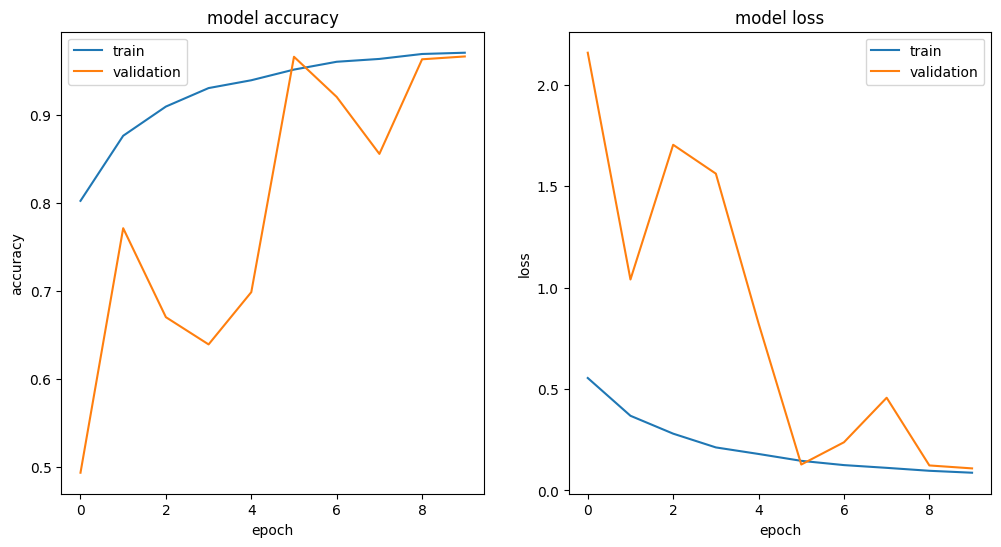

In [ ]:
# Checkpointing
CNBase_cp = callbacks('convnextbase_checkpoint')

# Fit the model
CNBase_hist = CNBase.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=[CNBase_cp, early_stopping]
)

# Plot training history
plot_hist(CNBase_hist)

In [ ]:
# Create the ResNet50V2 Base Model
base_model = ResNet50V2(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

RN50V2 = make_model_top(base_model, "ResNet50V2")
# Compile the model
optimizer = AdamW(learning_rate= 0.01, weight_decay=1e-3)

RN50V2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/resnet50v2_checkpoint'
RN50V2.load_weights(filepath, skip_mismatch=False)

In [ ]:
RN50V2.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23558528  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23572867 (89.92 MB)
Trainable params: 2352

Epoch 1/10
1225/1225 [==============================] - 154s 104ms/step - loss: 1.0219 - accuracy: 0.6504 - val_loss: 22.9472 - val_accuracy: 0.3567
Epoch 2/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.4838 - accuracy: 0.8258 - val_loss: 6.3118 - val_accuracy: 0.3937
Epoch 3/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.3059 - accuracy: 0.8958 - val_loss: 10.4858 - val_accuracy: 0.3440
Epoch 4/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.2554 - accuracy: 0.9144 - val_loss: 0.2944 - val_accuracy: 0.9031
Epoch 5/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.2283 - accuracy: 0.9211 - val_loss: 0.3445 - val_accuracy: 0.8930
Epoch 6/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.2329 - accuracy: 0.9209 - val_loss: 0.8713 - val_accuracy: 0.8027
Epoch 7/10
1225/1225 [==============================] - 127s 104ms/step - loss: 0.1883 - accuracy: 0.9369 - va

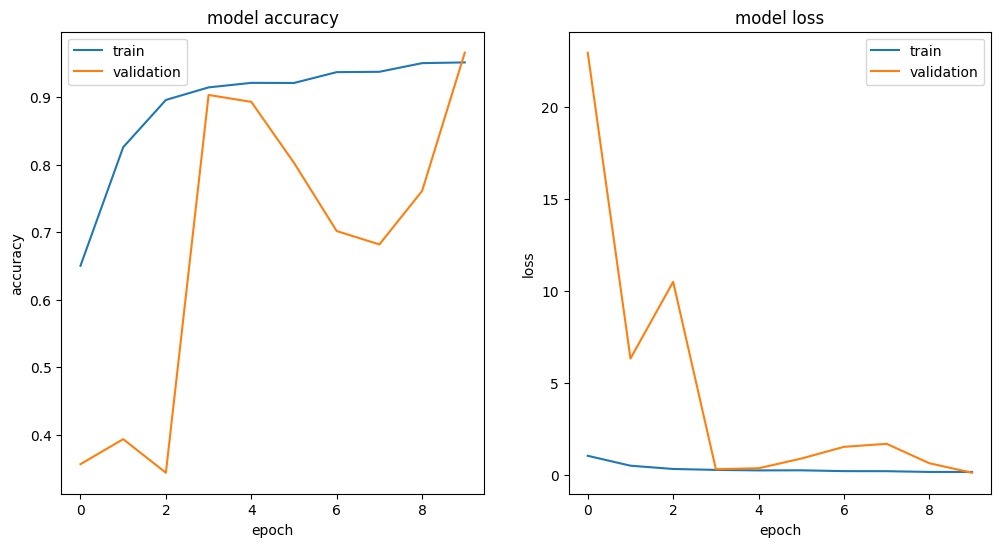

In [ ]:
# Checkpointing
RN50V2_cp = callbacks('resnet50v2_checkpoint')

# Fit the model
RN50V2_hist = RN50V2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=RN50V2_cp
)

# Plot training history
plot_hist(RN50V2_hist)

In [ ]:
# %cp /content/resnet50v2_checkpoint.data-00000-of-00001 /content/drive/MyDrive/Colab\ Notebooks/CSCI\ E-25

In [ ]:
# Create the ResNet101V2 Base Model
base_model = ResNet101V2(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

RN101V2 = make_model_top(base_model, "ResNet101V2")
# Compile the model
optimizer = AdamW(learning_rate= 0.01, weight_decay=1e-3)

RN101V2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/resnet101v2_checkpoint'
RN101V2.load_weights(filepath, skip_mismatch=False)

In [ ]:
RN101V2.summary()

Model: "ResNet101V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 16, 16, 2048)      42620288  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 42634627 (162.64 MB)
Trainable params: 42

Epoch 1/10
1225/1225 [==============================] - 270s 177ms/step - loss: 1.2527 - accuracy: 0.6239 - val_loss: 8.0865 - val_accuracy: 0.5066
Epoch 2/10
1225/1225 [==============================] - 215s 175ms/step - loss: 0.4355 - accuracy: 0.8429 - val_loss: 0.3316 - val_accuracy: 0.8812
Epoch 3/10
1225/1225 [==============================] - 215s 175ms/step - loss: 0.2998 - accuracy: 0.8929 - val_loss: 0.9472 - val_accuracy: 0.7516
Epoch 4/10
1225/1225 [==============================] - 215s 176ms/step - loss: 0.2626 - accuracy: 0.9061 - val_loss: 3.9225 - val_accuracy: 0.3910
Epoch 5/10
1225/1225 [==============================] - 215s 175ms/step - loss: 0.2545 - accuracy: 0.9100 - val_loss: 0.6172 - val_accuracy: 0.7548
Epoch 6/10
1225/1225 [==============================] - 215s 175ms/step - loss: 0.2285 - accuracy: 0.9217 - val_loss: 0.2203 - val_accuracy: 0.9271
Epoch 7/10
1225/1225 [==============================] - 215s 176ms/step - loss: 0.2015 - accuracy: 0.9294 - val_

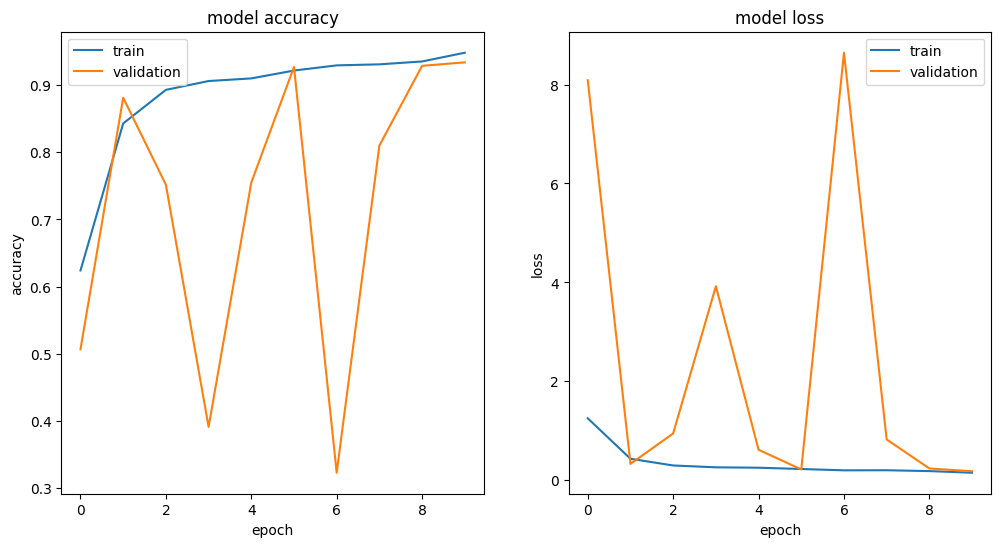

In [ ]:
# Checkpointing
RN101V2_cp = callbacks('resnet101v2_checkpoint')

# Fit the model
RN101V2_hist = RN101V2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=RN101V2_cp
)

# Plot training history
plot_hist(RN101V2_hist)

In [ ]:
# %cp /content/resnet101v2_checkpoint.data-00000-of-00001 /content/drive/MyDrive/Colab\ Notebooks/CSCI\ E-25

In [ ]:
# Create the ResNet152V2 Base Model
base_model = ResNet152V2(
    include_top=False,
    weights=None,
    input_shape=(512,512,1)
)
# freezing base model weights
# for layer in base_model.layers:
#     layer.trainable = False

RN152V2 = make_model_top(base_model, "ResNet152V2")
# Compile the model
optimizer = AdamW(learning_rate= 0.01, weight_decay=1e-3)

RN152V2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/CSCI E-25/resnet152v2_checkpoint'
RN152V2.load_weights(filepath, skip_mismatch=False)

In [ ]:
RN152V2.summary()

Model: "ResNet152V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 16, 16, 2048)      58325376  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 58339715 (222.55 MB)
Trainable params: 58

Epoch 1/10
1399/1399 [==============================] - 424s 236ms/step - loss: 1.1168 - accuracy: 0.6044 - val_loss: 7.7347 - val_accuracy: 0.3499
Epoch 2/10
1399/1399 [==============================] - 325s 233ms/step - loss: 0.5427 - accuracy: 0.7847 - val_loss: 0.5015 - val_accuracy: 0.8438
Epoch 3/10
1399/1399 [==============================] - 326s 233ms/step - loss: 0.3283 - accuracy: 0.8849 - val_loss: 2.3961 - val_accuracy: 0.4707
Epoch 4/10
1399/1399 [==============================] - 326s 233ms/step - loss: 0.2937 - accuracy: 0.9004 - val_loss: 110.8206 - val_accuracy: 0.4073
Epoch 5/10
1399/1399 [==============================] - 326s 233ms/step - loss: 0.2686 - accuracy: 0.9087 - val_loss: 1.3914 - val_accuracy: 0.6176
Epoch 6/10
1399/1399 [==============================] - 326s 233ms/step - loss: 0.2554 - accuracy: 0.9138 - val_loss: 1.4735 - val_accuracy: 0.6907
Epoch 7/10
1399/1399 [==============================] - 327s 233ms/step - loss: 0.2305 - accuracy: 0.9238 - va

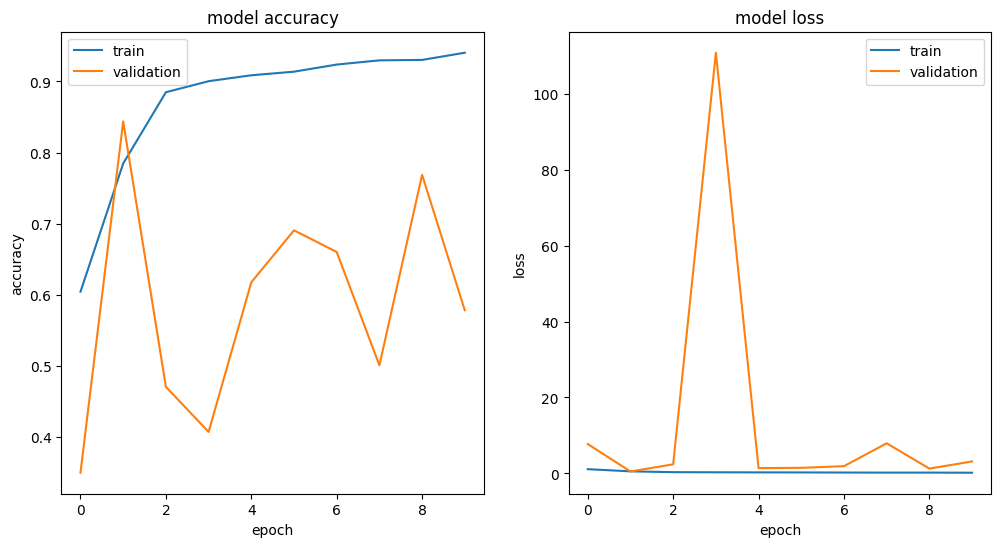

In [ ]:
# Checkpointing
RN152V2_cp = callbacks('resnet152v2_checkpoint')

# Fit the model
RN152V2_hist = RN152V2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_epochs,
    callbacks=RN152V2_cp
)

# Plot training history
plot_hist(RN152V2_hist)

In [ ]:
# %cp /content/resnet152v2_checkpoint.data-00000-of-00001 /content/drive/MyDrive/Colab\ Notebooks/CSCI\ E-25/data

## Initial Training Conclusions

Model training time varied wildly depending on the number of parameters present within each model as well as the complexity of each architecture. The ConvNeXt models took the longest and would at times crash the kernel or google colab entirely, resulting in the need to completely restart training. The cause of this was never fully determined.

### Key takeaways:
- ConvNeXt and EfficientNetV2 showed the best training behaviors, across all sizes. Models showed progression toward convergence by epoch 10.
- ResNetV2 struggled significantly with training. Initial learning rate parameters that were utilized for ConvNeXt and EfficientNetV2 models could note be used here. A custom AdamW optimizer with a high initial learning rate and a gradual decay showed the best results.
- All models displayed occasional sporadic test loss and test accuracy degredations as training progressed. I suspect that with more training epochs, these jitters would be smoothed out and the models would confidently achieve convergence.

# Model Testing and Conclusions <div id="model_testing">

With the training across all models complete, we can now procede with testing the efficacy of the models.

Overall, the best performing series of models belongs to the EfficientNetV2 architecture and it's separate sub-architectures. Those models consistently trained and test the best out of all 9 models, with a 94.7% average accuracy when classifying images in the testing dataset. The next best was the ConvNeXt architecture. ResNetV2 displays some serious issues in training with the models hardly showing any convergence by the end of their 10th training cycle.

---

### Confusion Matrices

To provide a general sense of how well a model can predict a given class, we look toward the confusion matrix to provide metrics about how well the model performed. This is in the form of a TP/FP/TN/FP matrix, though in this case we are dealing with a multi-class classification problem.

#### EfficientNetV2
All three models were able to successfuly classify the overwhelming majority of the test images correctly. Additionally, the models show no bias towards predicting a particular class.

#### ConvNeXt
Most notable is the poor performance of the smallest model of this group. CNTiny displayed strong biases towards classifying almost all images as being non-informative. The larger two models show a significant improvement over CNTiny, with classification performance similar to that of the EfficientNetV2 models.

#### ResNetV2
Despite the models showing relatively decent confusion matrix values here, we must note that these values are likely to be anomalous.


---

### Classification Reports

Diving into the finer details, we can see in the following classification reports each model's respective performance metrics.

These values are shown as Precision/Recall values, with the F1 Score being the overall result, and are derived from the TP/FP/TN/FP values previously seen.

#### EfficientNetV2
These models consistently showed good accuracy and recall metrics, with all the lowest f1 score among the three models being 0.94, which is exceptional. We can see that regardless of the model size used, all three models were able to generalize well.

#### ConvNeXt
The smallest model of the ConvNeXt architecture, ConvNeXtTiny, performed the worst out of the three model configurations. Despite it still having a considerable number trainable parameters, approximately 28 million, the model failed to generalize well. This is supported by the training graphs above where we can see that the CNTiny model overfit to the data as the training accuracies improved whereas the validation scores were erratic.

The other two model configurations performed exceptionally well, having high f1 score metrics, and having training graphs which show model convergence.

#### ResNetV2
Again, despite the models showing decent testing performance for the final epoch, inspecting their training graphs that these results are likely not reproducable if trained again and should therefore be regarded with skepticism. This notion is supported by the fact that the largest model of the three configurations, ResNet152V2, trained poorly and has poor precision, recall, and f1 metrics.

---

### ROC Curves and AUC

These graphs show the performance of the classification models at various classification thresholds. This provides another visualization of the previous metrics. From these graphs, the most notable standout here is the poor performance of ResNet152V2, and less so CNTiny, which show weaker classification abilities. Nonetheless, the AuC values are all above 0.9 which would indicate excellent performance. It is therefore important to note that just relying on this metric alone is not recommended for determining the efficacy of a given model.

All other models show very strong predictive abilities, reaching an almost perfect classifier state.

---

## Conclusions

Ultimately, I conclude that of the model architectures tested, EfficientNetV2 shows the most promise for this type of medical dataset. All models belonging to this architecture showed a remarkable ability to successfully classify the various image classes. Such classification models show promise as tools for medical professionals. This would aid them with their work, reducing the time to diagnosis, and potentially increasing their ability provide care where necessary.

Some limitations of this project include compute resources. While I originally intended to train all models locally on my machine, I encountered VRAM issues which forced me to utilize my backup strategy of training on Google Colab. Another limitation is domain specific knowledge. This project was performed with only cursory knowledge of the medical field. Subsequent research had to be performed in order to expand understanding of the materials used in this notebook.

Future works including this data would include the training existing EfficientNetV2 models, as well as larger EfficientNetV2 models, for significantly more epochs and testing to see if proper convergence can be reached. Likewise, it would be of academic interest to see if the model could then be used for transfer learning and applied to other medical images which require classification tasks performed.


In [ ]:
# calculating all necessary loss, accuracy, predictions, and classification reports for each model
loss_B0, acc_B0 = EffNetV2B0.evaluate(test_dataset)
pred_B0 = EffNetV2B0.predict(X_test)
pred_B0_labels = np.argmax(pred_B0, axis=1)
report_B0 = classification_report(y_test, pred_B0_labels, output_dict=True)

loss_B1, acc_B1 = EffNetV2B1.evaluate(test_dataset)
pred_B1 = EffNetV2B1.predict(X_test)
pred_B1_labels = np.argmax(pred_B1, axis=1)
report_B1 = classification_report(y_test, pred_B1_labels, output_dict=True)

loss_B2, acc_B2 = EffNetV2B2.evaluate(test_dataset)
pred_B2 = EffNetV2B2.predict(X_test)
pred_B2_labels = np.argmax(pred_B2, axis=1)
report_B2 = classification_report(y_test, pred_B2_labels, output_dict=True)

loss_CT, acc_CT = CNTiny.evaluate(test_dataset)
pred_CT = CNTiny.predict(X_test)
pred_CT_labels = np.argmax(pred_CT, axis=1)
report_CT = classification_report(y_test, pred_CT_labels, output_dict=True)

loss_CS, acc_CS = CNSmall.evaluate(test_dataset)
pred_CS = CNSmall.predict(X_test)
pred_CS_labels = np.argmax(pred_CS, axis=1)
report_CS = classification_report(y_test, pred_CS_labels, output_dict=True)

loss_CB, acc_CB = CNBase.evaluate(test_dataset)
pred_CB = CNBase.predict(X_test)
pred_CB_labels = np.argmax(pred_CB, axis=1)
report_CB = classification_report(y_test, pred_CB_labels, output_dict=True)

loss_RN5, acc_RN5 = RN50V2.evaluate(test_dataset)
pred_RN5 = RN50V2.predict(X_test)
pred_RN5_labels = np.argmax(pred_RN5, axis=1)
report_RN5 = classification_report(y_test, pred_RN5_labels, output_dict=True)

loss_RN10, acc_RN10 = RN101V2.evaluate(test_dataset)
pred_RN10 = RN101V2.predict(X_test)
pred_RN10_labels = np.argmax(pred_RN10, axis=1)
report_RN10 = classification_report(y_test, pred_RN10_labels, output_dict=True)

loss_RN15, acc_RN15 = RN152V2.evaluate(test_dataset)
pred_RN15 = RN152V2.predict(X_test)
pred_RN15_labels = np.argmax(pred_RN15, axis=1)
report_RN15 = classification_report(y_test, pred_RN15_labels, output_dict=True)

88/88 [==============================] - 19s 188ms/step


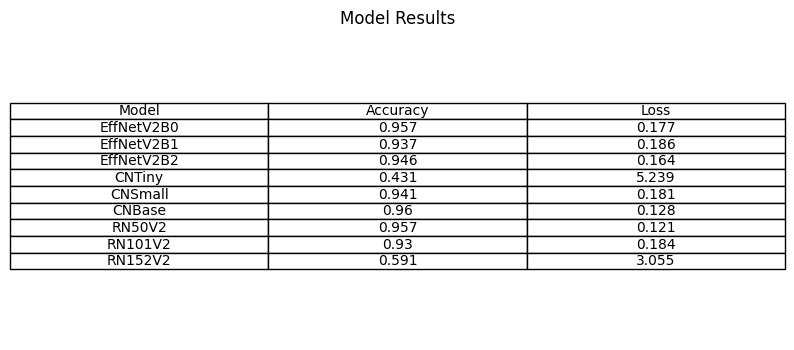

In [ ]:
# Lets plot out the base results into a table
models = ['EffNetV2B0', 'EffNetV2B1', 'EffNetV2B2', 'CNTiny', 'CNSmall', 'CNBase', 'RN50V2', 'RN101V2', 'RN152V2']
accuracies = [str(round(acc, 3)) for acc in [acc_B0, acc_B1, acc_B2, acc_CT, acc_CS, acc_CB, acc_RN5, acc_RN10, acc_RN15]]
losses = [str(round(loss, 3)) for loss in[loss_B0, loss_B1, loss_B2, loss_CT, loss_CS, loss_CB, loss_RN5, loss_RN10, loss_RN15]]
predictions = [pred_B0, pred_B1, pred_B2, pred_CT, pred_CS, pred_CB, pred_RN5, pred_RN10, pred_RN15]
reports = [report_B0, report_B1, report_B2, report_CT, report_CS, report_CB, report_RN5, report_RN10, report_RN15]

# Create a DataFrame
result_table = pd.DataFrame({'Model': models, 'Accuracy': accuracies, 'Loss': losses})

# Plot the DataFrame as a table
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.set_title('Model Results')
axs.axis('tight')
axs.axis('off')
axs.table(cellText=result_table.values, colLabels=result_table.columns, cellLoc = 'center', loc='center')

plt.show()

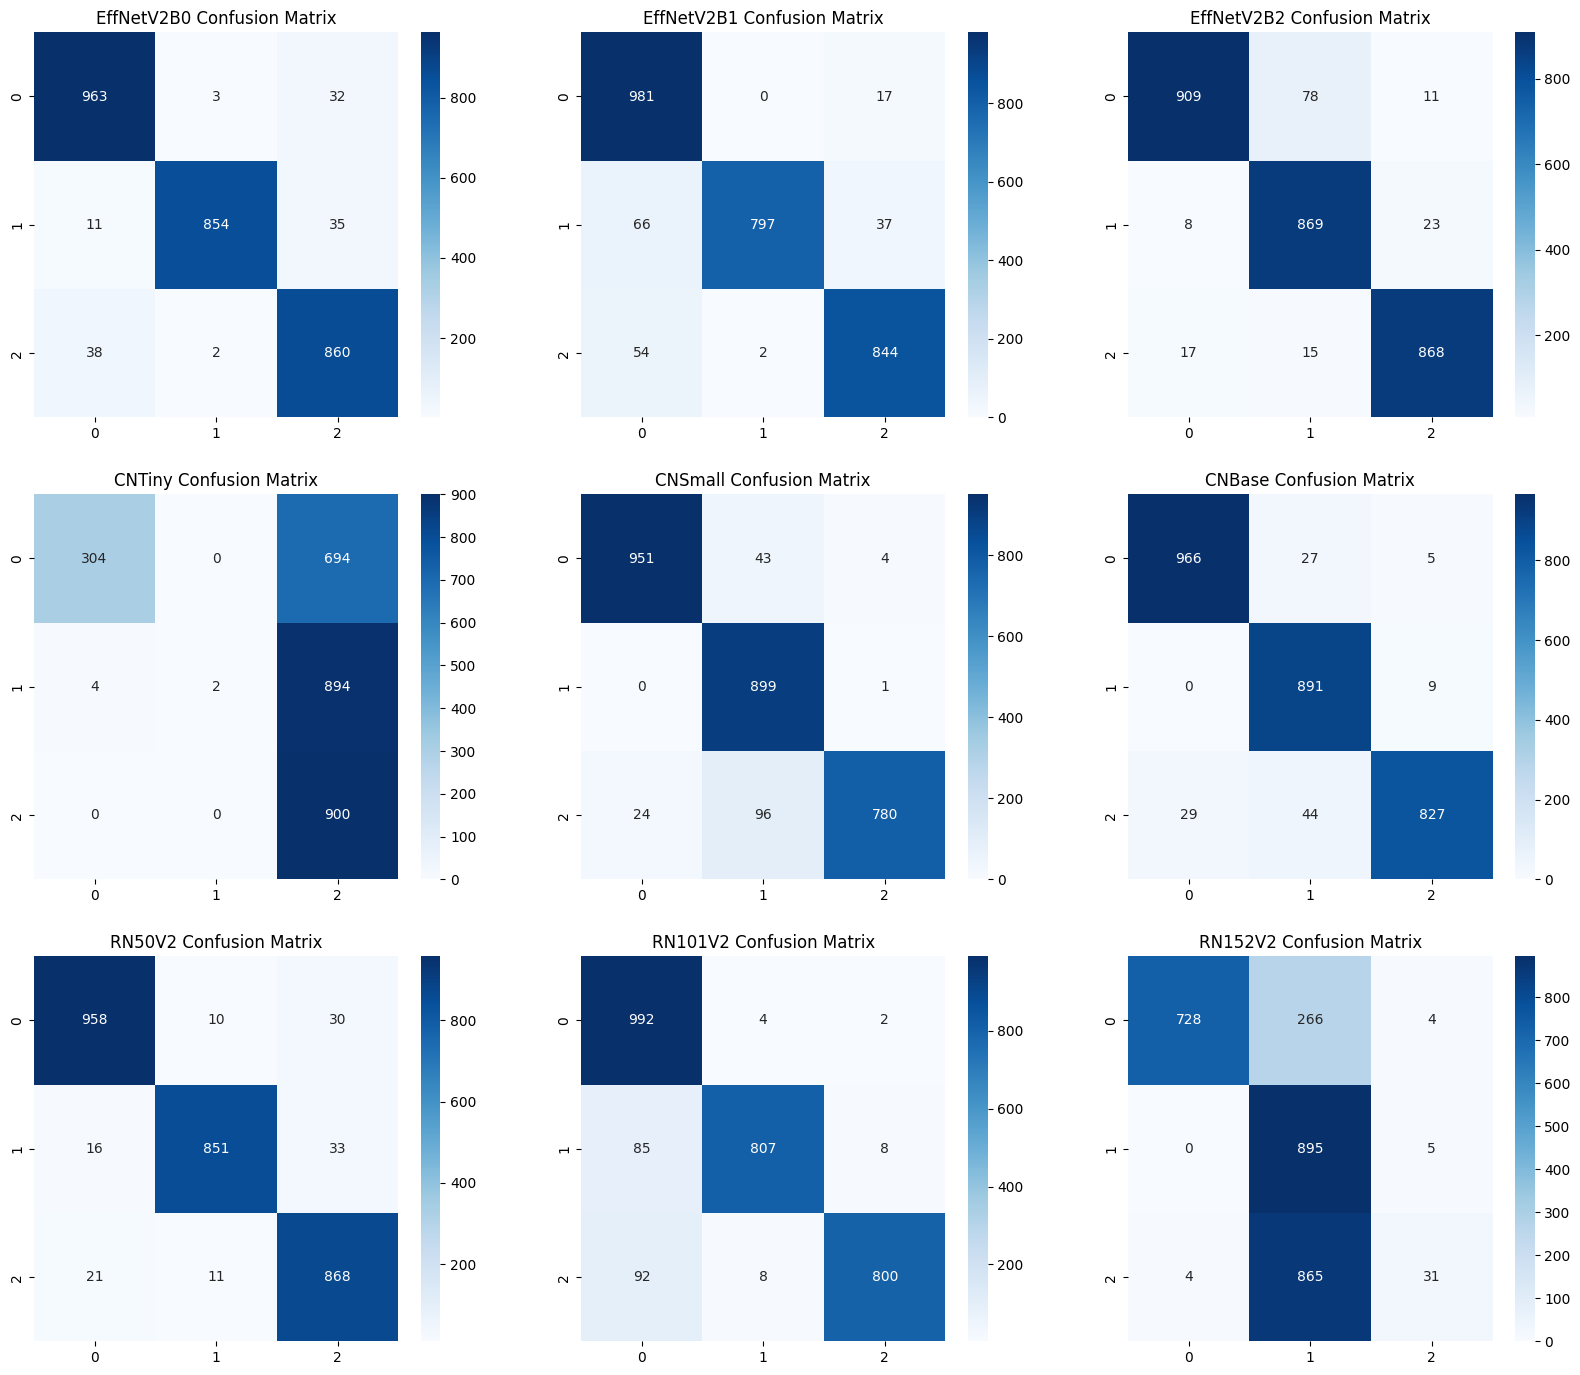

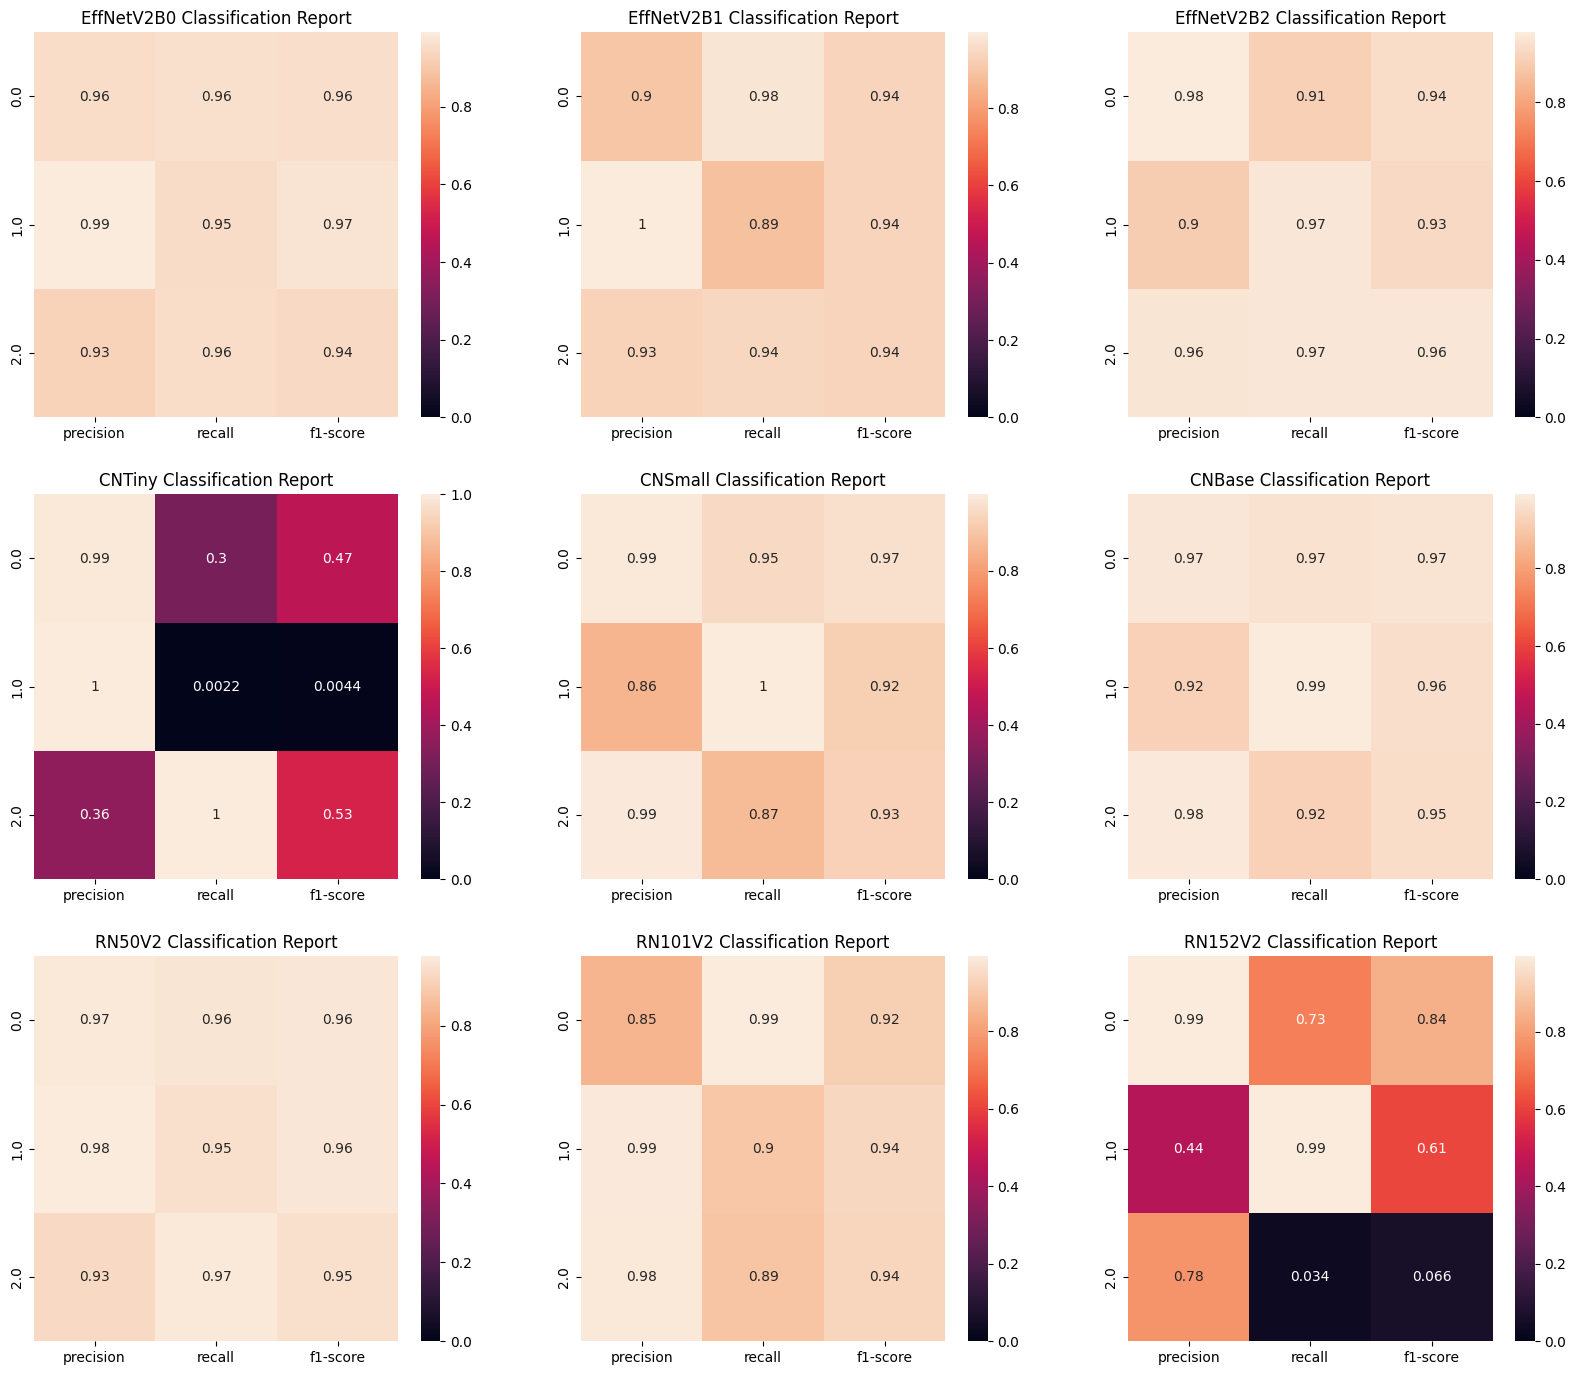

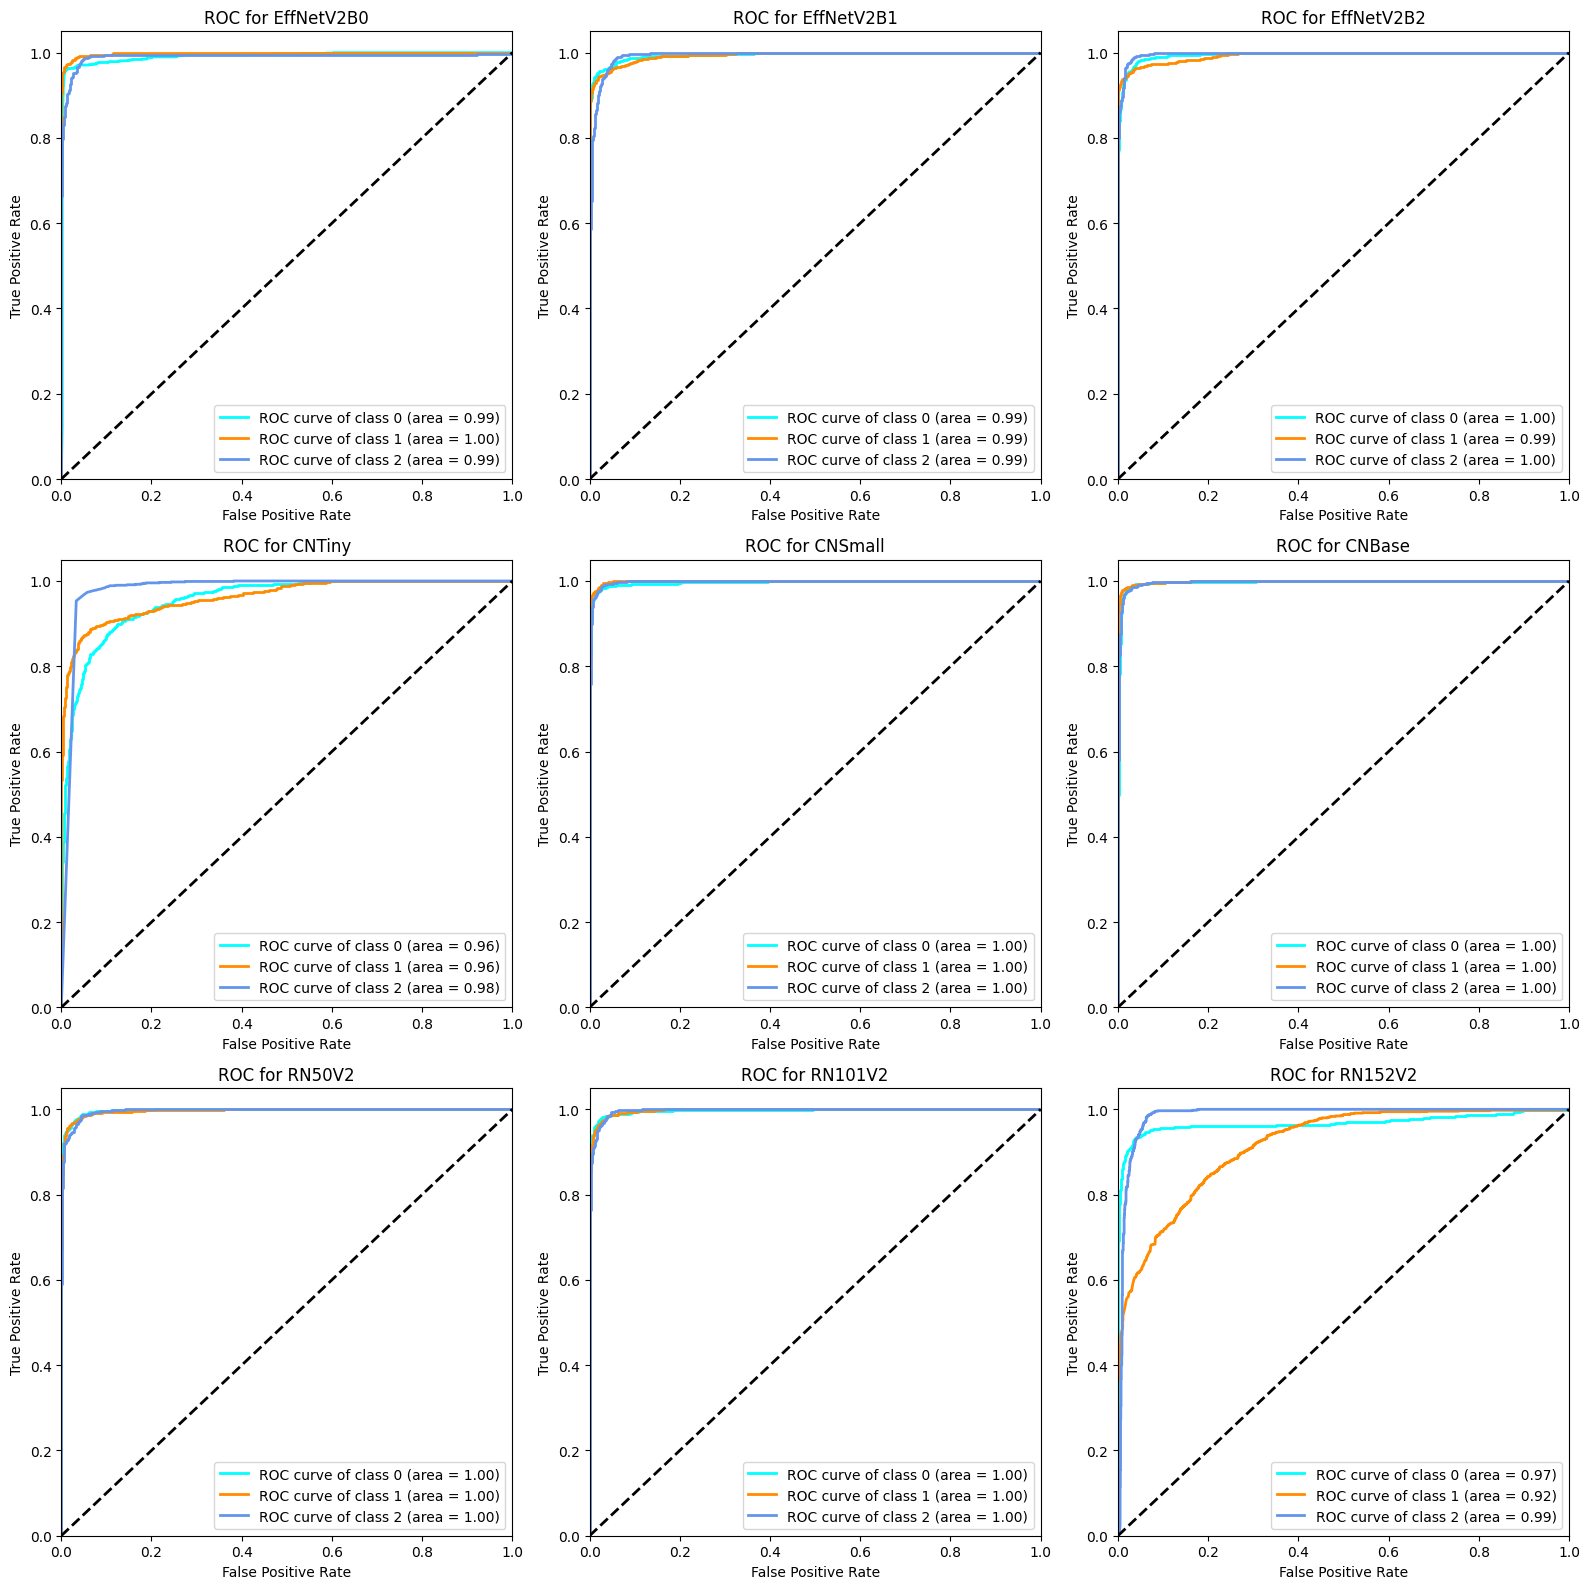

In [ ]:
# Binarize the output
true_labels_bin = label_binarize(y_test, classes=[0, 1, 2])
show_confusion_matrix(true_labels_bin, predictions, models)
show_classification_reports(reports, models)
plot_roc(predictions, models)

In [ ]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(true_labels_bin, predictions, models):
    fig, axs = plt.subplots(3, 3, figsize=(20, 17))

    # Loop through each model and plot the confusion matrix
    for i, model in enumerate(models):
        ax = axs[i//3, i%3]  # Select the current subplot

        y_pred = np.round(predictions[i])
        y_pred = np.argmax(y_pred, axis =1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d', ax=ax, cmap='Blues')
        ax.set_title(f'{model} Confusion Matrix')

    plt.show()


def show_classification_reports(reports, models):
    fig, axs = plt.subplots(3, 3, figsize=(20, 17))

    # Loop through each model and plot the classification report
    for i, model in enumerate(models):
        ax = axs[i//3, i%3]  # Select the current subplot
        report = reports[i] # each report is a dictionary

        report_df = pd.DataFrame.from_dict(report).transpose()

        # Plot the heatmap
        sns.heatmap(report_df.iloc[:3, :3], annot=True, cmap='rocket', vmin=0, ax=ax)
        ax.set_title(f'{model} Classification Report')

    plt.show()

def plot_roc(y_score, models):

    n_classes = 3  # Number of classes that we predicted
    lw = 2  # Line width

    # Setting colors for the lines
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

    fig, axs = plt.subplots(3, 3, figsize=(16, 16))

    for i, score in enumerate(y_score):
        ax = axs[i//3, i%3]  # Select the current subplot

        # Compute ROC curve and ROC area for each class
        # Create blank dictionaries to store our values
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Loop through each class and calculate the ROC curve for that class
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(true_labels_bin[:, j], score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot all ROC curves
        for j, color in zip(range(n_classes), colors):
            ax.plot(fpr[j], tpr[j], color=color, lw=lw,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                    ''.format(j, roc_auc[j]))

        # Add diagonal line for reference
        ax.plot([0, 1], [0, 1], 'k--', lw=lw)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC for {models[i]}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


def plot_loss_acc(losses, accs, models):
    fig, axs = plt.subplots(1, 2, figsize=(8,8))

    for i, model in enumerate(models):
        for subtype in model:
            axs[0].set_title('Loss across model subtype')
            axs[0].set_xlabel('Epochs')
            axs[0].set_ylabel('Loss')
            axs[0].plot(losses[i], label='Loss', marker='o')
            axs[0].xaxis.set_ticks(np.arange(1, 3, 1))
            axs[0].legend(models)

            axs[1].set_title('Accuracy across model subtype')
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Accuracy')
            axs[1].plot(accs[i], label='Accuracy', marker='o')
            axs[1].xaxis.set_ticks(np.arange(1, 3, 1))
            axs[1].legend(models)

    plt.show()

## Sources <div id="sources">

[1] Abu Zahid Bin Aziz. CT Scans for COVID-19 Classification. 2020. https://www.kaggle.com/datasets/azaemon/preprocessed-ct-scans-for-covid19

[2] Ning, Wanshang, et al. Open resource of clinical data from patients with pneumonia for the prediction of COVID-19 outcomes via deep learning. 2020. https://www.nature.com/articles/s41551-020-00633-5

[3] scikit-image team. Thresholding. https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding_guide.html

[4] scikit-image team. Comparing edge-based and region-based segmentation. https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py